In [2]:
import sys
sys.path.append('..')
from utils.visualize import *
from utils.spectrum import read_spectrum, denorm_spectrum, norm_spectrum
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
%matplotlib inline
specs = {}

# inspect data

In [3]:
df = pd.read_csv('/mnt/DATA/2D/pl_postech/super_resolution_metadata_20221130.csv')
df = pd.read_csv('/mnt/DATA/2D/pl_postech/super_resolution_metadata_20230626.csv')
sid_mask = np.array([True] * len(df))
sids = []
idxs = sorted(set(df.loc[sid_mask,['IDX1','IDX2']].values.reshape(-1)))
specs = {}
#for idx in tqdm.tqdm(idxs):
#    specs[idx] = read_spectrum(int(idx))

In [10]:
i = 0
part = df[df.SID == 95]

print('   ID\tRES1\tRES2\t IDX1\t IDX2')
for i, row in part[['RES1','RES2','IDX1','IDX2']].iterrows():
    print('{:5d}\t{:4d}\t{:4d}\t{:5d}\t{:5d}'.format(i, *row.values))
print()
cols = ['PL', 'LP', 'LW', 'IT', 'T', 'CEM', 'SUB', 'MET', 'SIZEx', 'SIZEy', 'SID']
string = ''
for i, col in enumerate(cols):
    string += f'{col:5s}\t{str(part[col].values[0]):15s}\t'
    if (i+1) % 3 == 0:
        print(string)
        string = ''
print(string)
    

   ID	RES1	RES2	 IDX1	 IDX2
  425	  10	  20	  774	  775
  426	  10	  40	  774	  776
  427	  10	  80	  774	  777
  428	  20	  40	  775	  776
  429	  20	  80	  775	  777
  430	  40	  80	  776	  777

PL   	1              	LP   	100            	LW   	632            	
IT   	1.0            	T    	300.15         	CEM  	WSe2           	
SUB  	SiO2/Si        	MET  	Exfoliation    	SIZEx	20.0           	
SIZEy	20.0           	SID  	95             	


In [11]:
pairs = [
[ 774, 776 ],
[ 775, 777 ],
[ 775, 776],
[ 776, 777]
]
col = 2

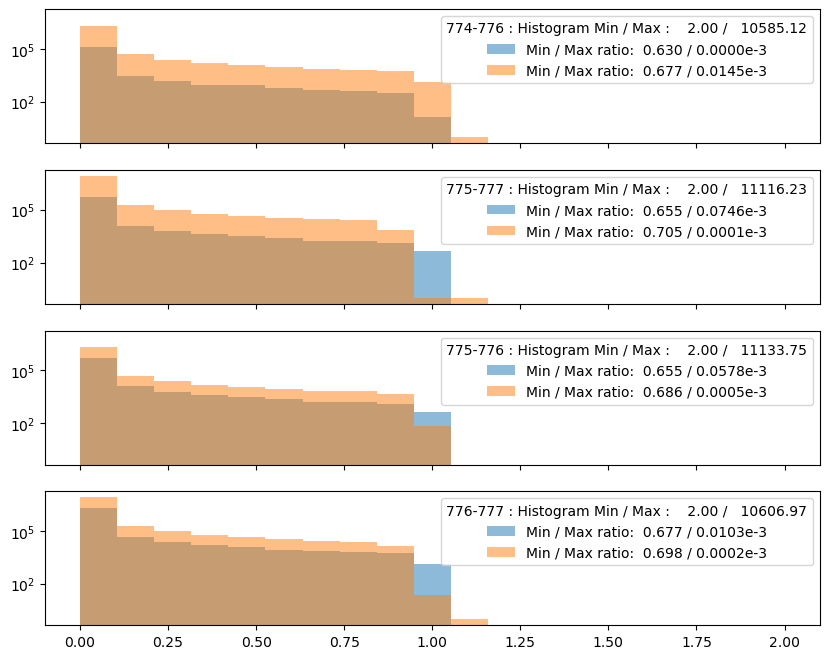

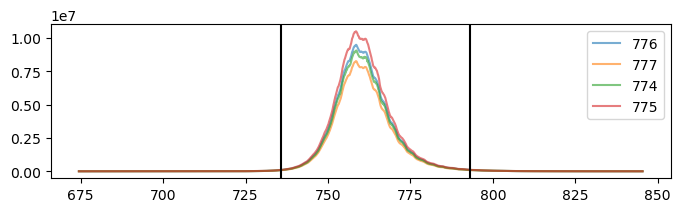

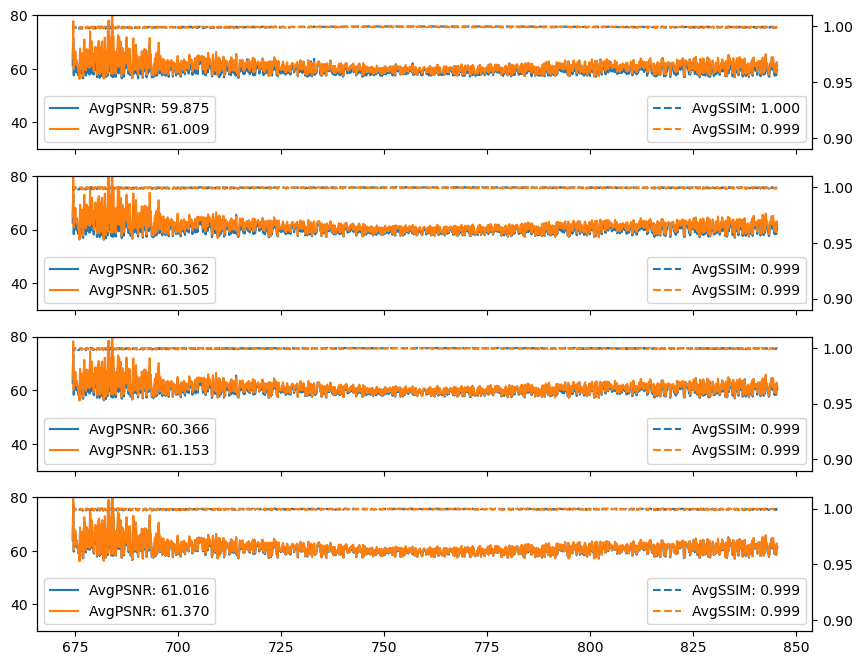

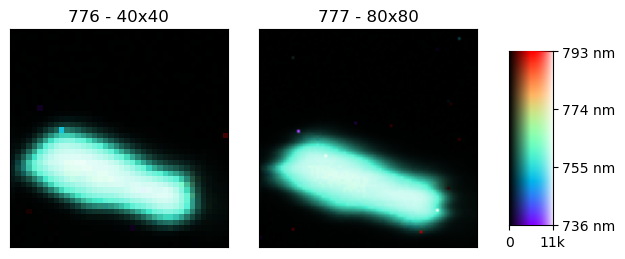

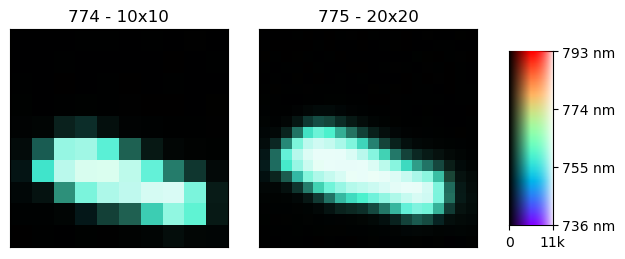

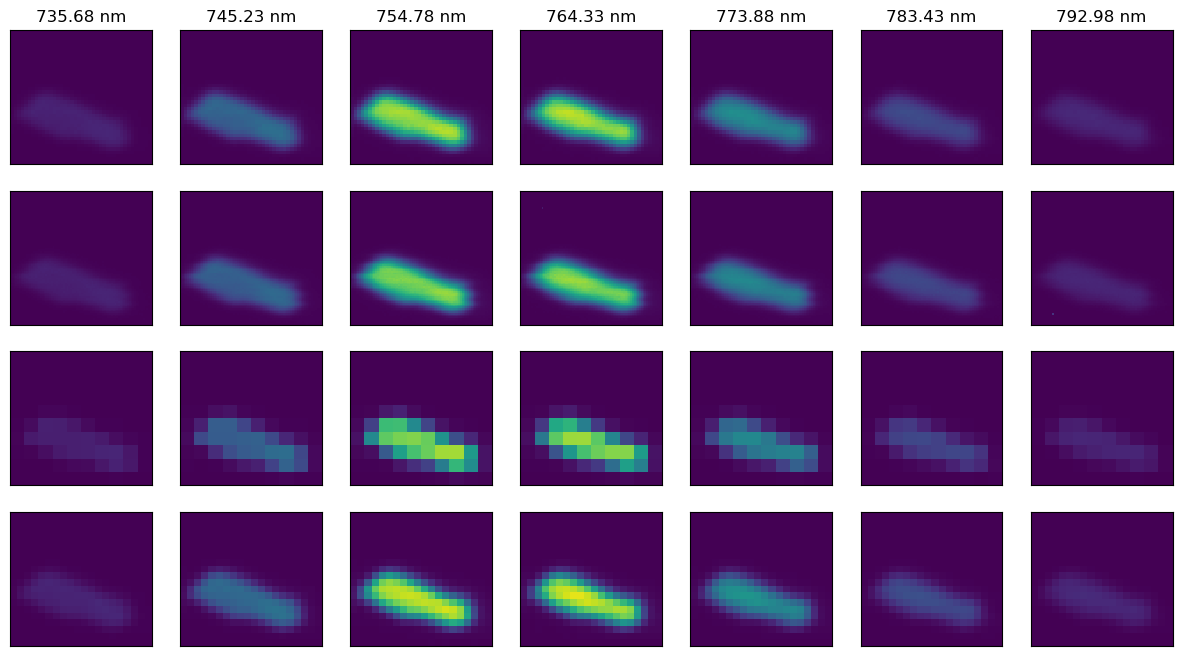

In [12]:
idxs = list(set(np.array(pairs).reshape(-1)))
f, axs = plt.subplots(len(pairs), 1, figsize=(10, 2*len(pairs)), sharex=True, sharey=True)
axs = np.array(axs)
n = 500
vmms = []
xmms = []
psnrs = []
ssims = []
for (idx1, idx2), ax in zip(pairs, axs.reshape(-1)):
    if idx1 not in specs.keys():
        specs[idx1] = read_spectrum(idx1, transpose_y=False)
    if idx2 not in specs.keys():
        specs[idx2] = read_spectrum(idx2, transpose_y=False)
    _, ys1 = specs[idx1]
    x, ys2 = specs[idx2]
    flat = np.hstack([ys1.reshape(-1), ys2.reshape(-1)])
    n1 = ys1.reshape(-1).shape[0]
    n2 = ys2.reshape(-1).shape[0]
    
    count, bins = np.histogram(flat, bins = np.linspace(np.min(flat) - 1, np.max(flat) + 1, n))
    bins = bins[:-1]
    vmin = flat[np.argsort(flat)[int(0.5 * np.max(count))]]
    vmax = bins[count > 8][-1]
    vmms.append((vmin, vmax))
    
    norm1 = (ys1 - vmin)/(vmax-vmin)
    norm2 = (ys2 - vmin)/(vmax-vmin)
    img1 = np.round(255 * norm1).astype(float)/255
    img2 = np.round(255 * norm2).astype(float)/255
    psnr = []
    ssim = []
    for i in range(x.shape[0]):
        i1 = np.clip(img1[..., i], 0, 1)
        i2 = np.clip(img2[..., i], 0, 1)
        o1 = np.clip(norm1[..., i], 0, 1)
        o2 = np.clip(norm2[..., i], 0, 1)
        psnr.append([PSNR(o1, i1), PSNR(o2, i2)])
        try:
            ssim.append([SSIM(o1, i1), SSIM(o2, i2)])
        except:
            ssim.append([0,SSIM(o2, i2)])
    psnrs.append(np.array(psnr).T)
    ssims.append(np.array(ssim).T)
    
    stack = np.vstack([img1.reshape(-1, x.shape[0]), img2.reshape(-1, x.shape[0])])
    stack[stack > 1] = 1
    xps = x[np.var(stack, axis=0) > 0.001]
    xmin = np.min(xps)
    xmax = np.max(xps)
    d = (x[1] - x[0]) * x.shape[0] * 0.01
    xmms.append((np.max([xmin - d, x[0]]), np.min([xmax + d, x[-1]])))
    
    ax.hist(img1.reshape(-1), alpha=0.5, bins=np.linspace(0,2,20), density=False, 
            label='Min / Max ratio: {:6.3f} / {:.4f}e-3'.format(np.sum(img1 <= 0)/n1, 1000*np.sum(img1 > 1)/n1))
    ax.hist(img2.reshape(-1), alpha=0.5, bins=np.linspace(0,2,20), density=False, 
            label='Min / Max ratio: {:6.3f} / {:.4f}e-3'.format(np.sum(img2 <= 0)/n2, 1000*np.sum(img2 > 1)/n2))
    ax.set_yscale('log')
    ax.legend(title='{}-{} : Histogram Min / Max : {:7.2f} / {:10.2f}'.format(idx1, idx2, vmin, vmax), loc='upper right')
#    print('Histogram Min / Max : {:12.2f} / {:12.2f}'.format(vmin, vmax))

xmms = np.array(xmms).T
xrange = np.max(xmms[0]), np.min(xmms[1])
yrange = np.mean(vmms, axis=0)

# variance
f, ax = plt.subplots(1, 1, figsize=(8, 2))
for idx in idxs:
    _ys = specs[idx][1]
    _ys[_ys > yrange[1]] = yrange[1]
    ax.plot(x, np.var(_ys.reshape(-1, x.shape[0]), axis=0), label=f'{idx}', alpha=0.6)
x1, x2 = xrange
ax.axvline(x1, color=[0,0,0])
ax.axvline(x2, color=[0,0,0])
ax.legend(loc='upper right')

# PSNR / SSIM
f, axs = plt.subplots(len(pairs), 1, figsize=(10, 2*len(pairs)), sharex=True)
axs = np.array(axs).reshape(len(pairs), 1)
for ax, psnr, ssim in zip(axs.reshape(-1), psnrs, ssims):
    ax.plot(x, psnr[0], label='AvgPSNR: {:.3f}'.format(np.mean(psnr[0])))
    ax.plot(x, psnr[1], label='AvgPSNR: {:.3f}'.format(np.mean(psnr[1])))
    ax1 = ax.twinx()
    ax1.plot(x, ssim[0], ls='--', label='AvgSSIM: {:.3f}'.format(np.mean(ssim[0])))
    ax1.plot(x, ssim[1], ls='--', label='AvgSSIM: {:.3f}'.format(np.mean(ssim[1])))
    ax.legend(loc='lower left')
    ax.set_ylim([30, 80])
    ax1.set_ylim([0.89, 1.01])
    ax1.legend(loc='lower right')

# Sample
if col == 2:
    size, wr = (7,4), [1,1,0.2]
if col == 3:
    size, wr = (8,4), [1,1,1,0.2]
n = len(idxs) // col
if len(idxs) % col != 0: n += 1
for i in range(n):
    f, axs = plt.subplots(1,col+1, figsize=size, gridspec_kw={'width_ratios':wr})
    for j in range(col):
        ax = axs[j]
        if i*col + j < len(idxs):
            idx = idxs[i*col + j]
            x, ys = specs[idx]
            ax.set_title(f'{idx} - {ys.shape[0]}x{ys.shape[1]}')
            plot_maxmap(ax, x, ys, xrange=xrange, 
                        yrange=yrange, cax=axs[-1], aspect_ratio=4)
        else:
            plot_maxmap(ax, x, np.ones_like(ys), yrange=[0,0.5])

locs = np.linspace(*xrange, 7)
f, axs = plt.subplots(len(idxs), len(locs), figsize=(15, len(idxs)*2))
for i, idx in enumerate(idxs):
    x, ys = specs[idx]
    for ax, loc in zip(axs[i], locs):
        plot_map(ax, x, ys, loc, tol=1, vmin=yrange[0], vmax=yrange[1])
        if i == 0: ax.set_title('{:.2f} nm'.format(loc))

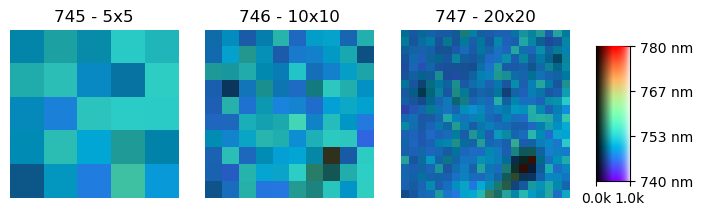

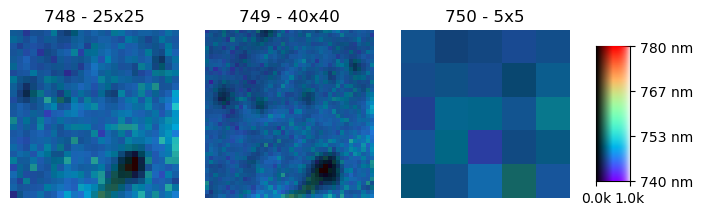

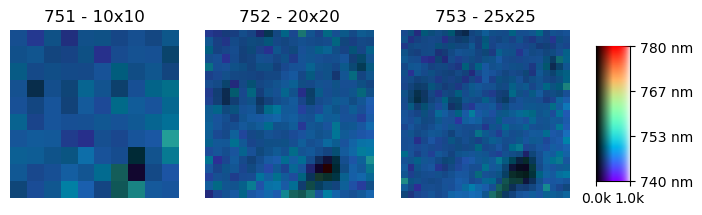

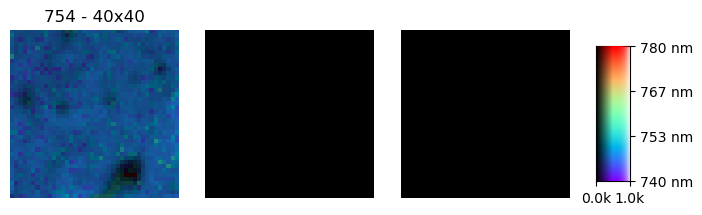

In [137]:

col = 3
#xrange = [600, 750]
xrange = [740, 780]
yrange = [0, 500]
idxs = [730, 731, 732, 733, 734]
idxs = [735, 736, 737, 738, 739, 740]
idxs = [741, 742, 743, 744]
idxs = [745, 746, 747, 748, 749, 750, 751, 752, 753, 754]


if col == 2:
    size, wr = (7,4), [1,1,0.2]
if col == 3:
    size, wr = (8,4), [1,1,1,0.2]
n = len(idxs) // col
if len(idxs) % col != 0: n += 1
for i in range(n):
    f, axs = plt.subplots(1,col+1, figsize=size, gridspec_kw={'width_ratios':wr})
    for j in range(col):
        ax = axs[j]
        if i*col + j < len(idxs):
            idx = idxs[i*col + j]
            if idx not in specs.keys():
                specs[idx] = read_spectrum(idx)
            x, ys = specs[idx]
            if idx != 0:
                ax.set_title(f'{idx} - {ys.shape[0]}x{ys.shape[1]}')
        else:
            x, ys = specs[0]
        plot_maxmap(ax, x, ys.reshape(-1, x.shape[0]), xrange=xrange, 
                    yrange=yrange, cax=axs[-1], aspect_ratio=4)


inf


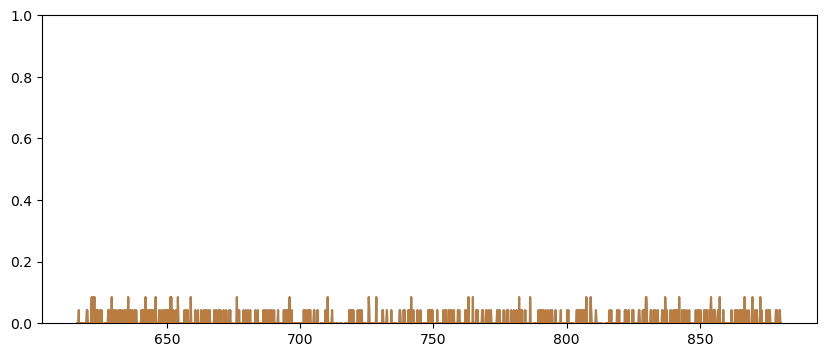

In [376]:
i = 200
f, ax = plt.subplots(1,1,figsize=(10,4))
norm_i = (norm2.reshape(-1, x.shape[0])[i])
orig_i = (ys2.reshape(-1, x.shape[0])[i] - vmin)/(vmax - vmin)
ax.plot(x, orig_i)
ax.plot(x, norm_i, alpha=.7)
ax.set_ylim([0,1])
#ax.axhline(1)
orig_i[orig_i > 1] = 1
norm_i[norm_i > 1] = 1
print(PSNR(norm_i, orig_i))
#ax.plot([775, 787, 787, 775, 775], [-0.01, -0.01, 0.09, 0.09, -0.01], color=[1,0,0])

(-0.01, 0.09)

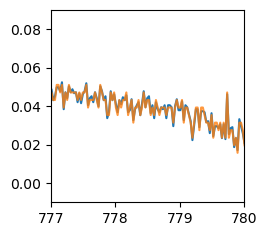

In [264]:
f, ax = plt.subplots(1,1,figsize=(2.5,2.5))
ax.plot(x, orig_i)
ax.plot(x, norm_i, alpha=0.8)
ax.set_xlim(777, 780)
ax.set_ylim(-0.01, 0.09)

In [ ]:
from utils.spectrum import spectrum_psnrs, spectrum_ssims
root = '/home/jhyang/WORKSPACES/MODELS/super_res/pl/s84_cvd_ws2/dbpn/finetune'
root = '/mnt/MODELS/super_res/pl/s84_cvd_ws2/dbpn/basetune/'
fn   = 'finetune/s00_2x_20'

for fn in os.listdir(os.path.join(root)):
    if '2x' not in fn: continue
    model_dir = os.path.join(root, fn)
    with open(os.path.join(model_dir, 'best.valid.pkl'),'rb') as f:
        best_dataset = pickle.load(f)
    with open(os.path.join(model_dir, '00100.valid.pkl'),'rb') as f:
        final_dataset = pickle.load(f)

    for k, fd in final_dataset.items():
        bd = best_dataset[k]
        i1, i2 = k.replace('(','').replace(')','').replace(',',' ').split()
        if i1 not in specs.keys():
            specs[i1] = read_spectrum(i1, root='/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum', transpose_y=True)
        if i2 not in specs.keys():
            specs[i2] = read_spectrum(i2, root='/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum', transpose_y=True)
        _, ys_i = specs[i1]
        x, ys_t = specs[i2]
        vmin = fd['vmin']
        vmax = fd['vmax']
        x_ = fd['x']
        idxs = np.argmin(np.abs(x.reshape(-1,1) - x_.reshape(1,-1)), axis=0)
        bic = np.zeros_like(ys_t)
        bp = np.zeros_like(ys_t)
        fp = np.zeros_like(ys_t)
        var = np.var(fd['bic'][:,0].reshape(x_.shape[0], -1), axis=1)
        psnrs = [spectrum_psnrs(fd['tgt'], fd['bic']), spectrum_psnrs(fd['tgt'], bd['pred']), spectrum_psnrs(fd['tgt'], fd['pred'])]
        ssims = [spectrum_ssims(fd['tgt'], fd['bic']), spectrum_ssims(fd['tgt'], bd['pred']), spectrum_ssims(fd['tgt'], fd['pred'])]
        bic[idxs] = fd['bic'][:,0]
        bp[idxs] = bd['pred'][:,0]
        fp[idxs] = fd['pred'][:,0]
        bic = denorm_spectrum(bic, vmin=vmin, vmax=vmax)
        bp = denorm_spectrum(bp, vmin=vmin, vmax=vmax)
        fp = denorm_spectrum(fp, vmin=vmin, vmax=vmax)

        f, axs = plt.subplots(1, 5, figsize=(20,4))
        for i, ys in enumerate([ys_i, ys_t, bic, bp, fp]):
            plot_maxmap(axs[i], x, ys, xrange=[620,660], yrange=[vmin, vmax])
        axs[0].set_title(f'{fn} / {ys_i.shape[-1]} / {i1}')
        axs[1].set_title(f'{fn} / {ys_t.shape[-1]} / {i2}')
        for i in range(3):
            axs[i+2].set_title('{} / {:.2f} / {:.3f}'.format(fn, np.average(psnrs[i], weights=var), np.average(ssims[i], weights=var)))


In [ ]:
from utils.spectrum import spectrum_psnrs, spectrum_ssims
root = '/mnt/MODELS/super_res/pl/s84_cvd_ws2/dbpn'
fn   = 'finetune/s00_2x_20'
locs = [630, 640, 650]
for fn in os.listdir(os.path.join(root, 'basetune')):
    if '2x' not in fn: continue
    model_dir = os.path.join(root, 'basetune', fn)
    with open(os.path.join(model_dir, 'best.valid.pkl'),'rb') as f:
        best_dataset = pickle.load(f)
    with open(os.path.join(model_dir, '00100.valid.pkl'),'rb') as f:
        final_dataset = pickle.load(f)

    for k, fd in final_dataset.items():
        bd = best_dataset[k]
        i1, i2 = k.replace('(','').replace(')','').replace(',',' ').split()
        if i1 not in specs.keys():
            specs[i1] = read_spectrum(i1, root='/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum', transpose_y=True)
        if i2 not in specs.keys():
            specs[i2] = read_spectrum(i2, root='/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum', transpose_y=True)
        _, ys_i = specs[i1]
        x, ys_t = specs[i2]
        vmin = fd['vmin']
        vmax = fd['vmax']
        x_ = fd['x']
        idxs = np.argmin(np.abs(x.reshape(-1,1) - x_.reshape(1,-1)), axis=0)
        bic = np.zeros_like(ys_t)
        bp = np.zeros_like(ys_t)
        fp = np.zeros_like(ys_t)
        var = np.var(fd['bic'][:,0].reshape(x_.shape[0], -1), axis=1)
        psnrs = [spectrum_psnrs(fd['tgt'], fd['bic']), spectrum_psnrs(fd['tgt'], bd['pred']), spectrum_psnrs(fd['tgt'], fd['pred'])]
        ssims = [spectrum_ssims(fd['tgt'], fd['bic']), spectrum_ssims(fd['tgt'], bd['pred']), spectrum_ssims(fd['tgt'], fd['pred'])]
        bic[idxs] = fd['bic'][:,0]
        bp[idxs] = bd['pred'][:,0]
        fp[idxs] = fd['pred'][:,0]
        bic = denorm_spectrum(bic, vmin=vmin, vmax=vmax)
        bp = denorm_spectrum(bp, vmin=vmin, vmax=vmax)
        fp = denorm_spectrum(fp, vmin=vmin, vmax=vmax)

        f, axs = plt.subplots(len(locs), 5, figsize=(20,8))
        for i, loc in enumerate(locs):
            for j, ys in enumerate([ys_i, ys_t, bic, bp, fp]):
                plot_map(axs[i,j], x, ys, loc=loc, tol=1, vmin=vmin, vmax=vmax)
        axs[0,0].set_title(fn)
        for i in range(3):
            axs[0,i+2].set_title('{:.2f} / {:.3f}'.format(np.average(psnrs[i], weights=var), np.average(ssims[i], weights=var)))


In [ ]:
from utils.spectrum import spectrum_psnrs, spectrum_ssims
root = '/mnt/MODELS/super_res/pl/s84_cvd_ws2/dbpn/basetune/'
root = '/home/jhyang/WORKSPACES/MODELS/super_res/pl/s84_cvd_ws2/dbpn/basetune'

def get_output(i1, i2, root, mult=2, ds='valid', epoch=60):
    global specs
    output = {}
    if i1 not in specs.keys():
        specs[i1] = read_spectrum(i1, root='/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum', transpose_y=True)
    if i2 not in specs.keys():
        specs[i2] = read_spectrum(i2, root='/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum', transpose_y=True)
    x, ys_i = specs[i1]
    x, ys_t = specs[i2]
    _, _, ys_tn = norm_spectrum(ys=ys_t, ref=ys_i)
    ys_tn = ys_tn.astype(float)/255
    k = f'({i1}, {i2})'
    output = [ys_i, ys_t, None, None]
    title  = [f'{i1} / {ys_i.shape[1:]}', f'{i2} / {ys_t.shape[1:]}', None, None]
    measure = [None, None, None, None]
    for fn in os.listdir(os.path.join(root)):
        if f'{mult}x' not in fn: continue
        model_dir = os.path.join(root, fn)
        with open(os.path.join(model_dir, f'best.{ds}.pkl'),'rb') as f:
            best_dataset = pickle.load(f)
        with open(os.path.join(model_dir, f'{epoch:05d}.{ds}.pkl'),'rb') as f:
            final_dataset = pickle.load(f)
        fd = final_dataset[k]
        bd = best_dataset[k]
        vmin = fd['vmin']
        vmax = fd['vmax']
        x_ = fd['x']
        idxs = np.argmin(np.abs(x.reshape(-1,1) - x_.reshape(1,-1)), axis=0)
        bp = np.zeros_like(ys_t)
        fp = np.zeros_like(ys_t)
        var = np.zeros_like(x)
        var[idxs] = np.var(fd['bic'][:,0].reshape(x_.shape[0], -1), axis=1)
        bp[idxs] = bd['pred'][:,0]
        fp[idxs] = fd['pred'][:,0]
        psnr = spectrum_psnrs(ys_tn, bp)
        ssim = spectrum_ssims(ys_tn, bp)
        measure.append([psnr, ssim, var])
        title.append('{}-best\n{:.3f} / {:.2f}'.format(fn, np.average(psnr, weights=var), np.average(ssim, weights=var)))
        psnr = spectrum_psnrs(ys_tn, fp)
        ssim = spectrum_ssims(ys_tn, fp)
        measure.append([psnr, ssim, var])
        title.append('{}-fin\n{:.3f} / {:.2f}'.format(fn, np.average(psnr, weights=var), np.average(ssim, weights=var)))
        bp = denorm_spectrum(bp, vmin=vmin, vmax=vmax)
        fp = denorm_spectrum(fp, vmin=vmin, vmax=vmax)
        output.append(bp)
        output.append(fp)
    vmin = fd['vmin']
    vmax = fd['vmax']
    x_ = fd['x']
    idxs = np.argmin(np.abs(x.reshape(-1,1) - x_.reshape(1,-1)), axis=0)
    tgt = np.zeros_like(ys_t)
    bic = np.zeros_like(ys_t)
    var = np.zeros_like(x)
    var[idxs] = np.var(fd['bic'][:,0].reshape(x_.shape[0], -1), axis=1)
    tgt[idxs] = bd['tgt'][:,0]
    bic[idxs] = fd['bic'][:,0]
    psnr = spectrum_psnrs(ys_tn, tgt)
    ssim = spectrum_ssims(ys_tn, tgt)
    measure[2] = [psnr, ssim, var]
    title[2] = 'tgt / {:.3f} / {:.2f}'.format(np.average(psnr, weights=var), np.average(ssim, weights=var))
    psnr = spectrum_psnrs(ys_tn, bic)
    ssim = spectrum_ssims(ys_tn, bic)
    measure[3] = [psnr, ssim, var]
    title[3] = 'bic / {:.3f} / {:.2f}'.format(np.average(psnr, weights=var), np.average(ssim, weights=var))
    tgt = denorm_spectrum(tgt, vmin=vmin, vmax=vmax)
    bic = denorm_spectrum(bic, vmin=vmin, vmax=vmax)
    output[2] = tgt
    output[3] = bic
    nrow = len(output) // 4 + int(bool(len(output) % 4))
    f, axs = plt.subplots(nrow, 4, figsize=(20, 5*nrow))
    for ax, out, tit, m in zip(axs.reshape(-1), output, title, measure):
        plot_maxmap(ax, x, out, xrange=[600, 700], yrange=[vmin, vmax])
        ax.set_title(tit)
    return f, output, title, measure

f, outputs, titles, measures = get_output(691, 694, root, mult=4, epoch=70)

In [15]:
os.listdir('/home/jhyang/WORKSPACES/MODELS/super_res/pl/s61/dbpn/finetune/s00_2x/00025.valid')

['419.txt', '421_2x_419.txt']

In [4]:
sorted(os.listdir('/home/jhyang/WORKSPACES/MODELS/super_res/pl/cs/s80/dbpn/finetune/s00_2x' + '/00030.output'))

['671_None_16x.txt',
 '671_None_32x.txt',
 '671_None_4x.txt',
 '671_None_8x.txt',
 '672_None_16x.txt',
 '672_None_4x.txt',
 '672_None_8x.txt',
 '673_None_4x.txt',
 '673_None_8x.txt',
 '674_676_2x.txt',
 '674_676_4x.txt',
 'None_676_2x.txt',
 'None_676_4x.txt']

In [12]:
from utils.spectrum import get_mask
epoch, root = 30, '/home/jhyang/WORKSPACES/MODELS/super_res/pl/cs/s80/dbpn/finetune/s00_2x'
i5, i10, i20, i40, i80 = 671, 672, 673, 674, 676
specs = {
    '5':read_spectrum(i5),
    '10':read_spectrum(i10),
    '20':read_spectrum(i20),
    '40':read_spectrum(i40),
    '80':read_spectrum(i80),
    '5x32' :read_spectrum(f'{epoch:05d}.output/{i5}_None_32x.txt', root=root),
    '10x16':read_spectrum(f'{epoch:05d}.output/{i10}_None_16x.txt', root=root),
    '20x8' :read_spectrum(f'{epoch:05d}.output/{i20}_None_8x.txt', root=root),
    '40x4a':read_spectrum(f'{epoch:05d}.output/{i40}_{i80}_4x.txt', root=root),
    '40x4b':read_spectrum(f'{epoch:05d}.output/None_{i80}_4x.txt', root=root),
    
#    '20x2':read_spectrum(f'{epoch:05d}.output/{i1}_2x_{i2}.txt', root=root),
#    '20x4':read_spectrum(f'{epoch:05d}.test/{i1}_4x.txt', root=root),
#    '20x8':read_spectrum(f'{epoch:05d}.test/{i1}_8x.txt', root=root),
#    '40x2':read_spectrum(f'{epoch:05d}.valid/{i2}_2x_{i3}.txt', root=root),
#    '40x4':read_spectrum(f'{epoch:05d}.test/{i2}_4x.txt', root=root),
}
mask = np.ones(1600, dtype=bool)
x = specs['5'][0]
for i, (ki, vi) in enumerate(specs.items()):
    mask = mask & get_mask(x, vi[0])
x_ref = x[mask]
print(np.sum(mask))

500


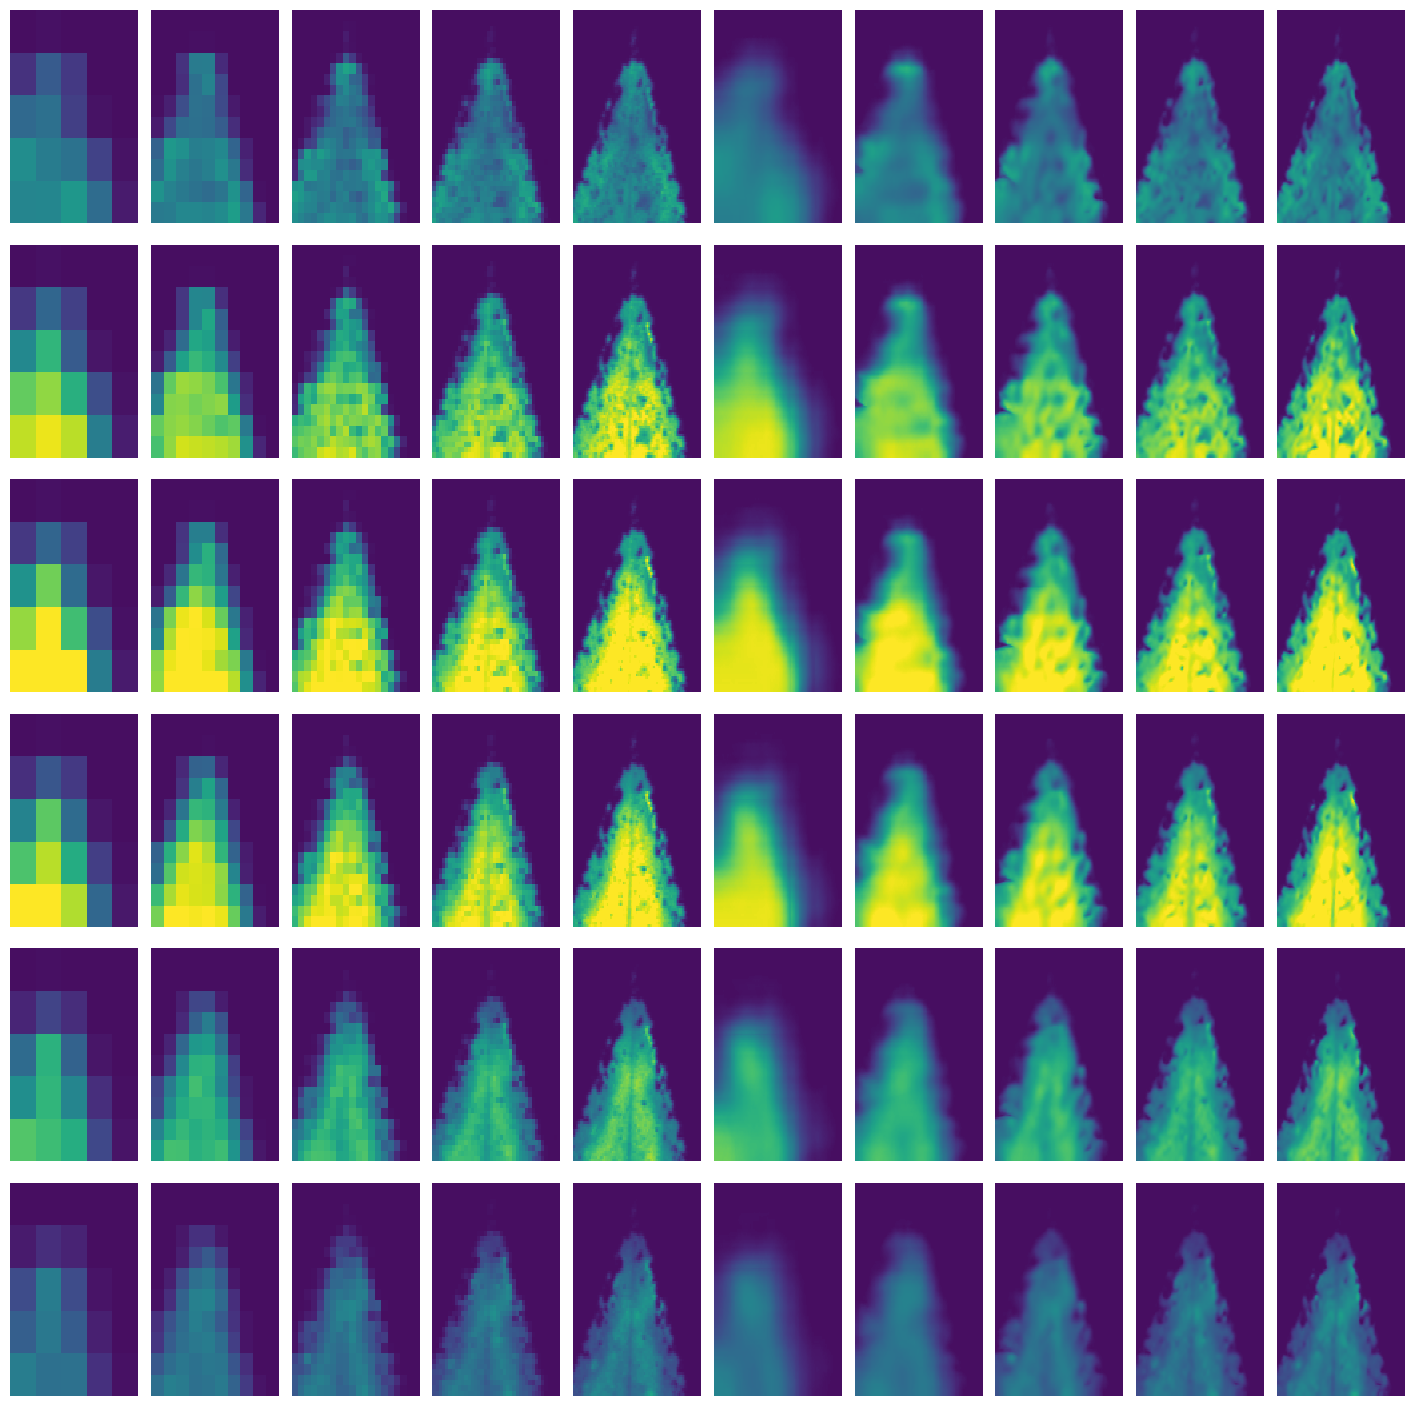

In [14]:
locs = [625, 630, 635, 640, 645, 650]
f, axs = plt.subplots(len(locs), len(specs), figsize=(18, 18))
for ax, loc in zip(axs, locs):
    for _ax, (x, y) in zip(ax, specs.values()):
        plot_map(_ax, x, y, loc, tol=2, vmin=700, vmax=1800)
        _ax.axis('off')
f.subplots_adjust(wspace=0.1, hspace=0.1)

In [123]:
x1, y1 = specs['80']
x2, y2 = specs['40x2']
ry1 = y1.reshape(x1.shape[0],-1).T
ry2 = y2.reshape(x2.shape[0],-1).T
v1 = np.var(ry1, axis=1)
v2 = np.var(ry2, axis=1)

(0, 512)

In [191]:
th = 1e-10
m = (v1 > th) & (v2 > th)
print(f'th: {th} / count: {np.sum(m)}')
corr = np.array([np.corrcoef(t, p)[0,1] for t,p in zip(ry1[m], ry2[m])])
#print(np.where(~m))

th: 1e-10 / count: 5511


/home/jhyang/anaconda3/envs/image/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jhyang/anaconda3/envs/image/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(nan, nan)

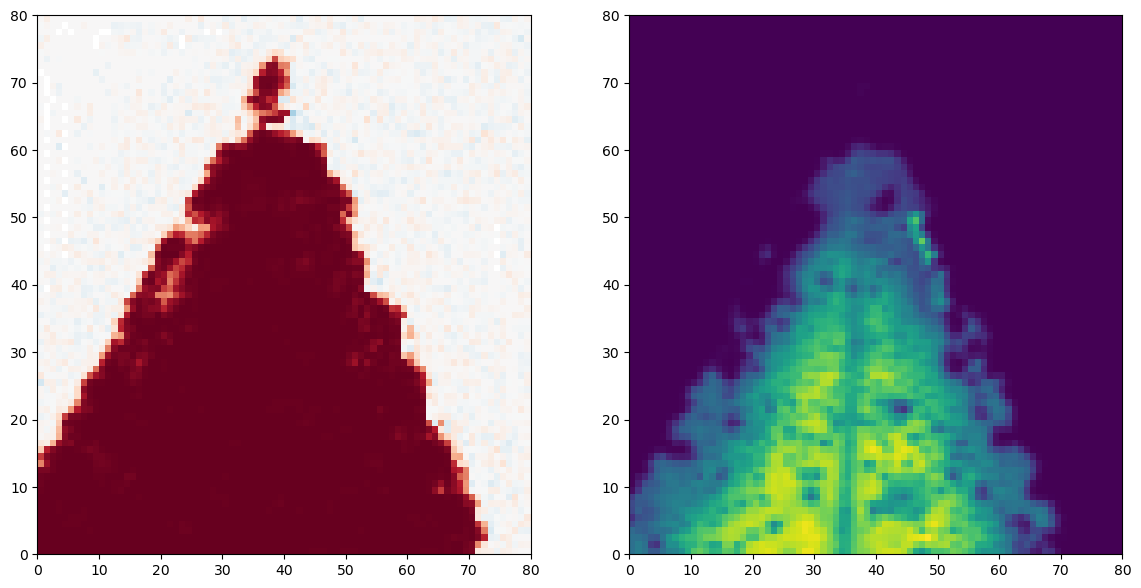

In [77]:
from utils.spectrum import spectrum_correlations, spectrum_psnrs, spectrum_ssims

x, ys = specs['80']
corrs = spectrum_correlations(specs['80'][1], specs['40x2'][1])
pvars = np.var(ys.reshape(x.shape[0], -1), axis=0)
xvars = np.var(ys.reshape(x.shape[0], -1), axis=1)
f, axs = plt.subplots(1,2,figsize=(14,7))
axs[0].pcolormesh(corrs.reshape(80,80), vmin=-1, vmax=1, cmap='RdBu_r')
axs[1].pcolormesh(pvars.reshape(80,80))
np.average(corrs), np.average(corrs, weights=vars)

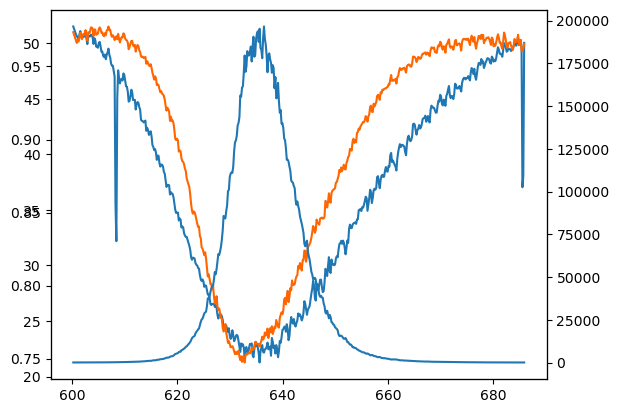

In [63]:
vmin, vmax, y1 = norm_spectrum(specs['40x2'][1], ref=None, mode='minmax')
_, _, y2 = norm_spectrum(specs['80'][1], vmin=vmin, vmax=vmax, mode='minmax')
psnrs = spectrum_psnrs(y1, y2)
ssims = spectrum_ssims(y1, y2)
plt.plot(specs['40x2'][0], psnrs)
plt.twinx().plot(specs['40x2'][0], ssims, color=[1,0.4,0])
plt.twinx().plot(specs['40x2'][0], xvars)

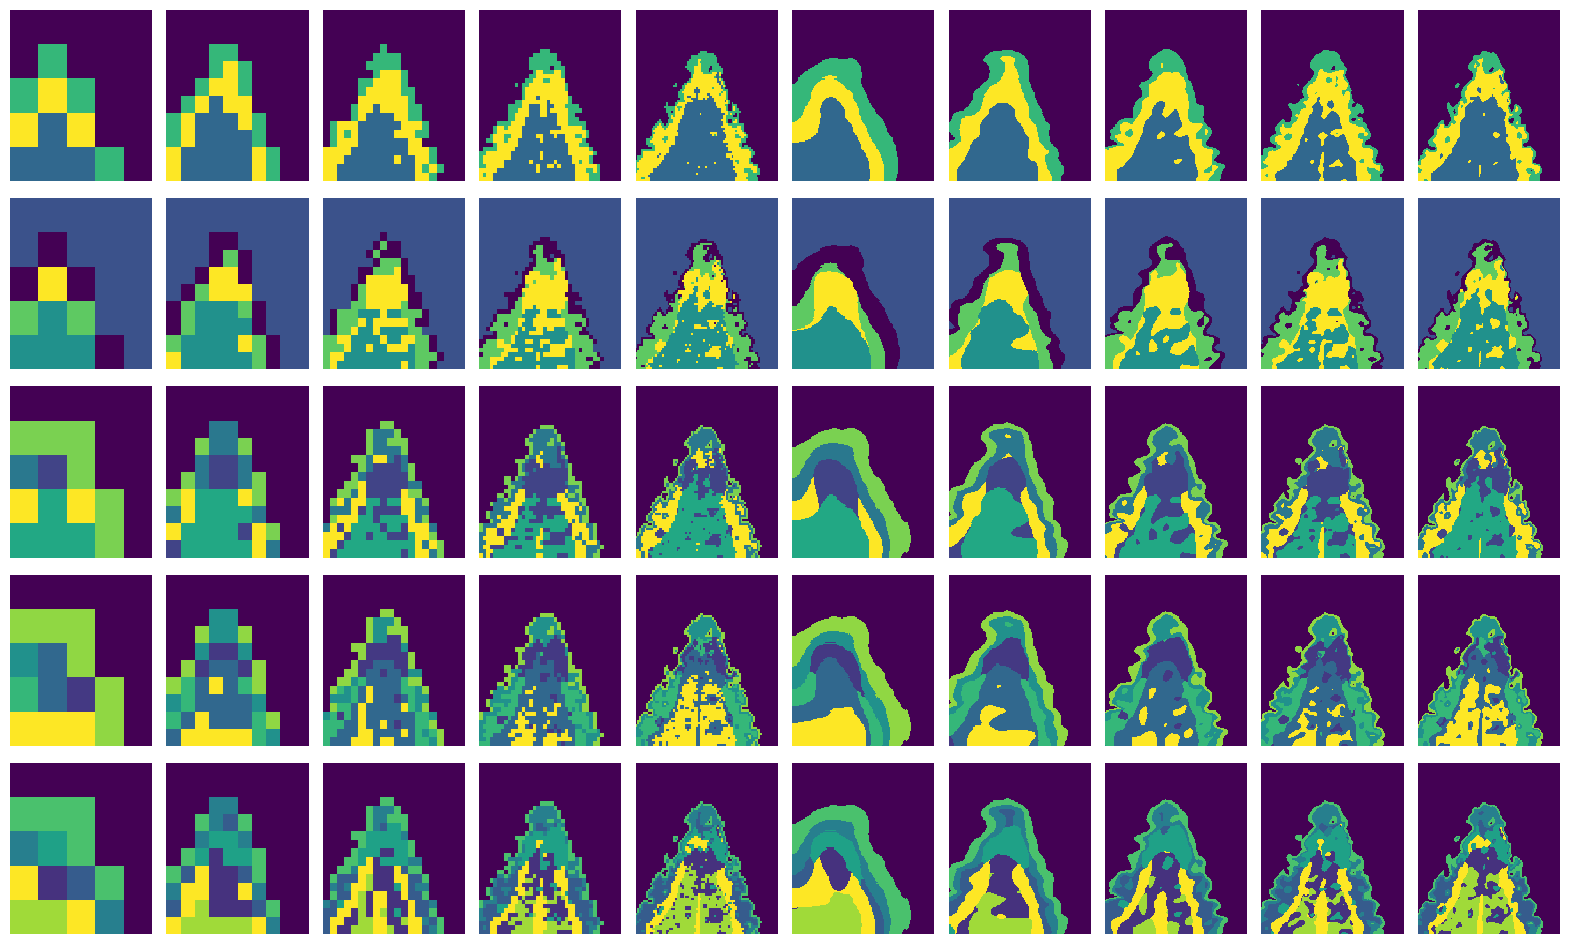

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
k1, k2 = 4, 9
f, axs = plt.subplots(k2-k1, len(specs), figsize=(20,12))
dists  = np.zeros((len(specs), k2-k1))
for i, n in enumerate(range(k1,k2)):
    km = KMeans(n_clusters=n)
    x0, ys0 = specs['80']
    mask = get_mask(x0, x_ref)
    km.fit(ys0.reshape(x0.shape[0],-1)[mask].T)
    lbls = {}
    for j, (k, (x1, ys1)) in enumerate(specs.items()):
        mask = get_mask(x1, x_ref)
        shape = ys1.shape[1:]
        pys = ys1.reshape(x1.shape[0],-1)[mask].T
        lbl = km.predict(pys)
        dists[j,i] = np.sum(np.square(km.cluster_centers_[lbl] - pys))
        axs[i,j].pcolormesh(lbl.reshape(shape))
        axs[i,j].axis('off')
        lbls[k] = lbl
#    print(f'k: {n} / f1_micro: {f1_score(lbls["80"], lbls["40x2"], average="micro"):.3f} / f1_macro: {f1_score(lbls["80"], lbls["40x2"], average="macro"):.3f}')
#for i, ax in enumerate(axs[-1]):
#    ax.plot(np.arange(k1,k2), dists[i])
f.subplots_adjust(wspace=0.1, hspace=0.1)

In [1]:
import sys
sys.path.append('..')
from utils.spectrumdata import SpectrumSRDataset, collate_fn, SpectrumAEDataset
from utils.spectrum import denorm_spectrum, read_spectrum, norm_spectrum
import numpy as np
import matplotlib.pyplot as plt
from utils.visualize import plot_map, plot_maxmap
from torch.utils.data import DataLoader
from srs.base_networks import ConvBlock, DeconvBlock
from srs.snet import SpectrumSuperResolutionNetwork, SpectrumAutoEncoder
from utils.trainer import SSRNetTrainer, SAETrainer
import torch, time

In [2]:
DS_train = SpectrumAEDataset(include_x=True)
DS_valid = SpectrumAEDataset(include_x=True)
DS_test = SpectrumAEDataset(include_x=True)
DS_train.from_fns(['666_2x_668.txt','668_2x_670.txt'], root='../test/dbpn/s79r/00050.valid/')
DS_valid.from_fns(['668.txt','670.txt'])
DS_test.from_fns(['666_8x.txt','668_4x.txt'], root='../test/dbpn/s79r/00050.test/')

Data generation...: 100%|██████████| 2/2 [00:28<00:00, 14.16s/it]


In [32]:
DS_train = SpectrumSRDataset(upscale_factor=2, include_x=True)
DS_valid = SpectrumSRDataset(upscale_factor=2, include_x=True)
DS_test = SpectrumSRDataset(upscale_factor=2, include_x=True)
DS_train.from_pairs([[None,668], [None,666]])
DS_valid.from_pairs([[668,670]])
DS_test.from_pairs([[670,None]])

Data generation...: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


In [3]:
train_dl = DataLoader(DS_train, batch_size=1024, shuffle=True, collate_fn=collate_fn)
valid_dl = DataLoader(DS_valid, batch_size=4096, collate_fn=collate_fn)
test_dl = DataLoader(DS_test, batch_size=4096, collate_fn=collate_fn)

In [4]:
x0, ys0 = read_spectrum(673)
x1, ys1 = read_spectrum(674)
x2, ys2 = read_spectrum(676)
#x3, ys3 = read_spectrum(694)

In [179]:
root = '/home/jhyang/WORKSPACES/MODELS/super_res/pl/cs/s80/dbpn/finetune/s00_2x/00030.output'
print(os.listdir(root))
px1, pys1 = read_spectrum('674_676_2x.txt', root=root)
px2, pys2 = read_spectrum('None_676_2x.txt', root=root)

['None_676_4x.txt', 'None_676_2x.txt', '674_676_2x.txt', '672_None_16x.txt', '671_None_4x.txt', '673_None_8x.txt', '671_None_8x.txt', '671_None_16x.txt', '671_None_32x.txt', '674_676_4x.txt', '672_None_4x.txt', '672_None_8x.txt', '673_None_4x.txt']


In [162]:
import torch
from torch.nn.functional import interpolate

ys1_u = interpolate(torch.tensor(ys1).float().unsqueeze(1), scale_factor=2, mode='bicubic').numpy().squeeze()
ys1_d = interpolate(torch.tensor(ys1).float().unsqueeze(1), scale_factor=0.5, mode='bicubic').numpy().squeeze()

ys2_u = interpolate(torch.tensor(ys2).float().unsqueeze(1), scale_factor=2, mode='bicubic').numpy().squeeze()
ys2_d = interpolate(torch.tensor(ys2).float().unsqueeze(1), scale_factor=0.5, mode='bicubic').numpy().squeeze()

#ys3_u = interpolate(torch.tensor(ys3).float().unsqueeze(1), scale_factor=2, mode='bicubic').numpy().squeeze()
#ys3_d = interpolate(torch.tensor(ys3).float().unsqueeze(1), scale_factor=0.5, mode='bicubic').numpy().squeeze()
#ys3_dd = interpolate(torch.tensor(ys3_d).float().unsqueeze(1), scale_factor=0.5, mode='bicubic').numpy().squeeze()

In [163]:
vmin, vmax, _ = norm_spectrum(ys2, ref=ys2, mode='histogram')

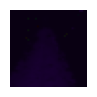

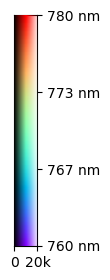

In [8]:
f, ax = plt.subplots(1,1,figsize=(1,1))
f, cax = plt.subplots(1,1,figsize=(4,3))
plot_maxmap(ax, x1, ys1, xrange=[760,780], yrange=[0, 19900], cax=cax, aspect_ratio=10)

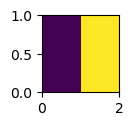

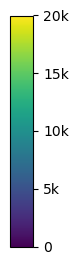

In [17]:
f, ax = plt.subplots(1,1,figsize=(1,1))
im = ax.pcolormesh([[0,20000]], vmin=0, vmax=20000)
f, cax = plt.subplots(1,1,figsize=(0.3,3))
plt.colorbar(im, cax=cax)
cax.set_yticks([i*5000 for i in range(5)], labels=['0'] + [f'{i*5}k' for i in range(1,5)])


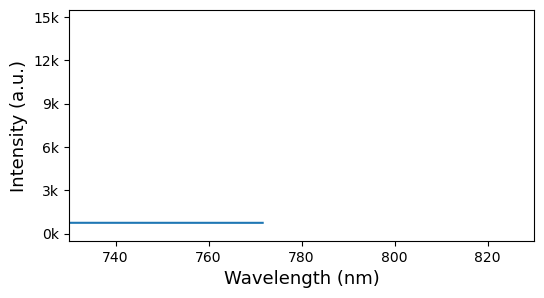

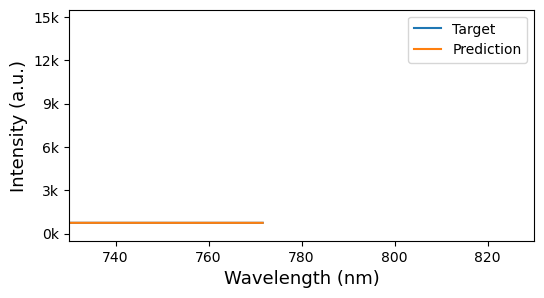

In [169]:
f, ax0 = plt.subplots(1, 1, figsize=(6, 3))
f, ax1 = plt.subplots(1, 1, figsize=(6, 3))
ax0.plot(x1[::3], ys1[::3,15,18])
ax1.plot(x2[::3],   ys2[::3,30,36], label='Target')
ax1.plot(x2[::3], ys1_u[::3,30,36], label='Prediction')
ax1.legend(loc='upper right')
for ax in [ax0, ax1]:
    ax.set_xlim([730, 830])
    ax.set_ylim([-500, 15500])
    ax.set_xlabel('Wavelength (nm)', fontsize=13)
    ax.set_ylabel('Intensity (a.u.)', fontsize=13)
    ax.set_yticks([i*3000 for i in range(6)], labels=[f'{3*i}k' for i in range(6)])


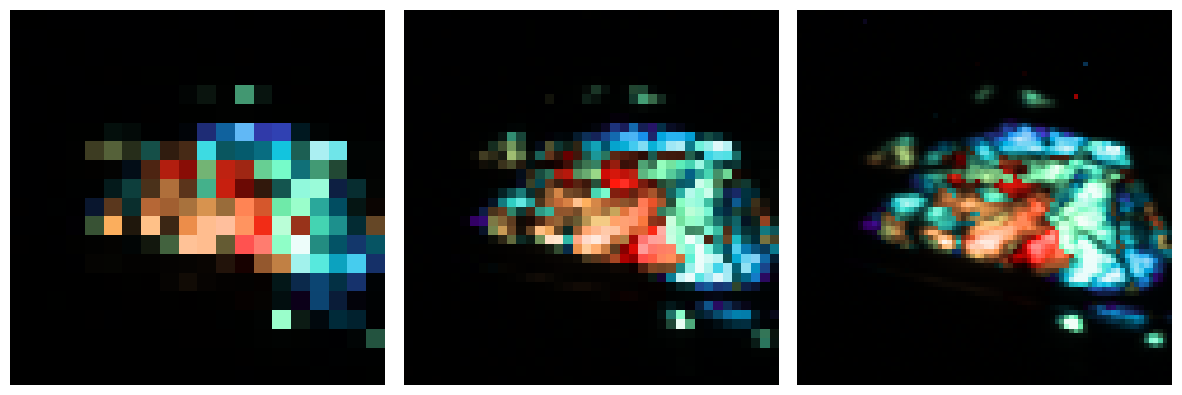

In [159]:
xrange=[750, 780]
f, axs = plt.subplots(1,3,figsize=(15, 5))
plot_maxmap(axs[0], x0, ys0, xrange=xrange, yrange=[vmin, vmax*0.9])
plot_maxmap(axs[1], x1, ys1, xrange=xrange, yrange=[vmin, vmax*0.9])
plot_maxmap(axs[2], x2, ys2, xrange=xrange, yrange=[vmin, vmax*0.9])
f.subplots_adjust(wspace=0.05)

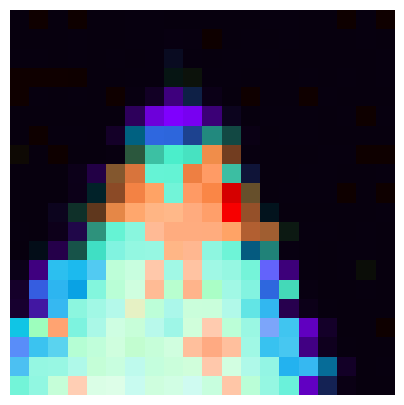

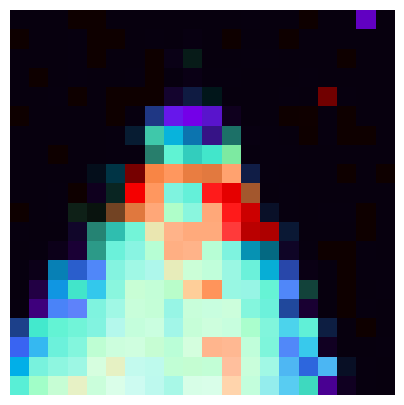

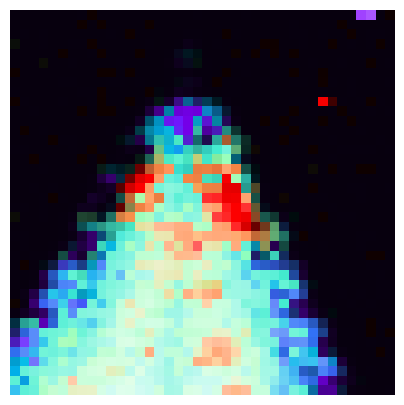

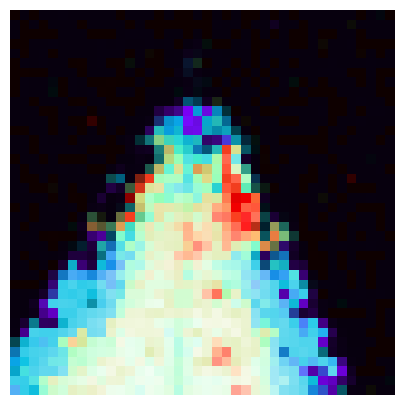

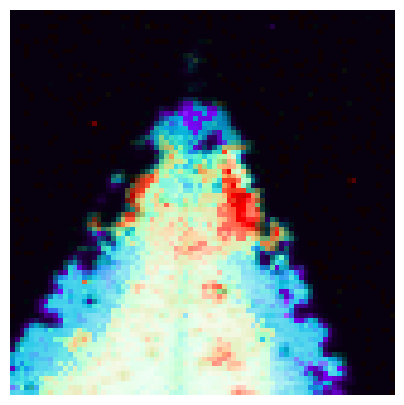

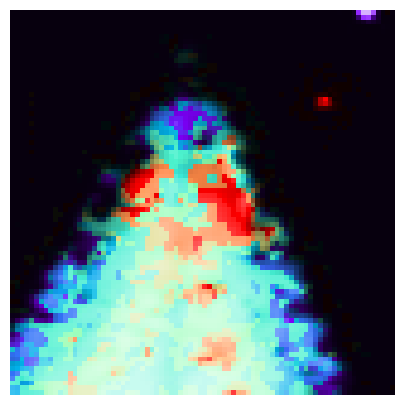

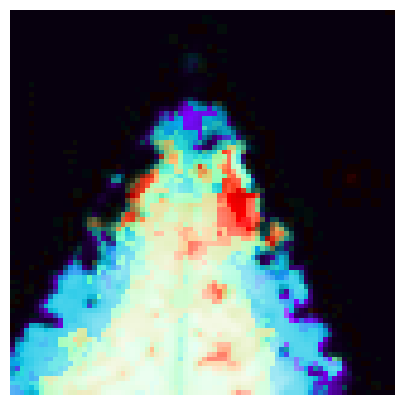

In [180]:
xrange=[630,640]
f, ax = plt.subplots(1,1,figsize=(5,5))
plot_maxmap(ax, x0, ys0, xrange=xrange, yrange=[vmin, vmax])
f, ax = plt.subplots(1,1,figsize=(5,5))
plot_maxmap(ax, x1, ys1_d, xrange=xrange, yrange=[vmin, vmax])

f, ax = plt.subplots(1,1,figsize=(5,5))
plot_maxmap(ax, x1, ys1, xrange=xrange, yrange=[vmin, vmax])

f, ax = plt.subplots(1,1,figsize=(5,5))
plot_maxmap(ax, x2, ys2_d, xrange=xrange, yrange=[vmin, vmax])
f, ax = plt.subplots(1,1,figsize=(5,5))
plot_maxmap(ax, x2, ys2, xrange=xrange, yrange=[vmin, vmax])

f, ax = plt.subplots(1,1,figsize=(5,5))
plot_maxmap(ax, px1, pys1, xrange=xrange, yrange=[vmin, vmax])
f, ax = plt.subplots(1,1,figsize=(5,5))
plot_maxmap(ax, px2, pys2, xrange=xrange, yrange=[vmin, vmax])


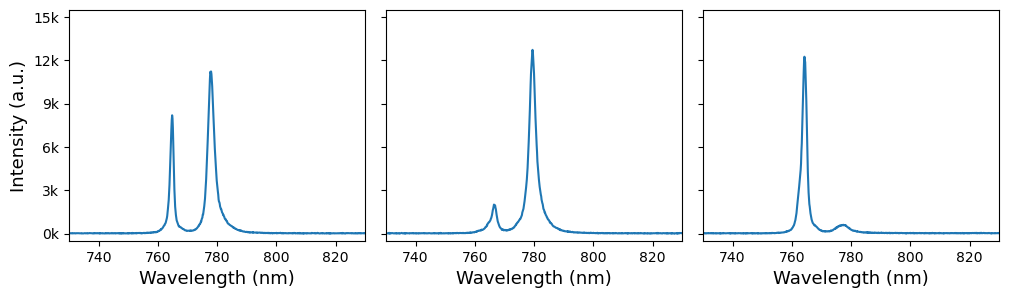

In [121]:
f, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)
axs[0].plot(x2, ys2[:, 30, 55])
axs[1].plot(x2, ys2[:, 30, 50])
axs[2].plot(x2, ys2[:, 30, 58])
axs[0].set_xlim([730, 830])
axs[0].set_ylim([-500, 15500])
axs[0].set_ylabel('Intensity (a.u.)', fontsize=13)
for ax in axs:
    ax.set_xlabel('Wavelength (nm)', fontsize=13)
    ax.set_yticks([i*3000 for i in range(6)], labels=[f'{3*i}k' for i in range(6)])

f.subplots_adjust(wspace=0.07)

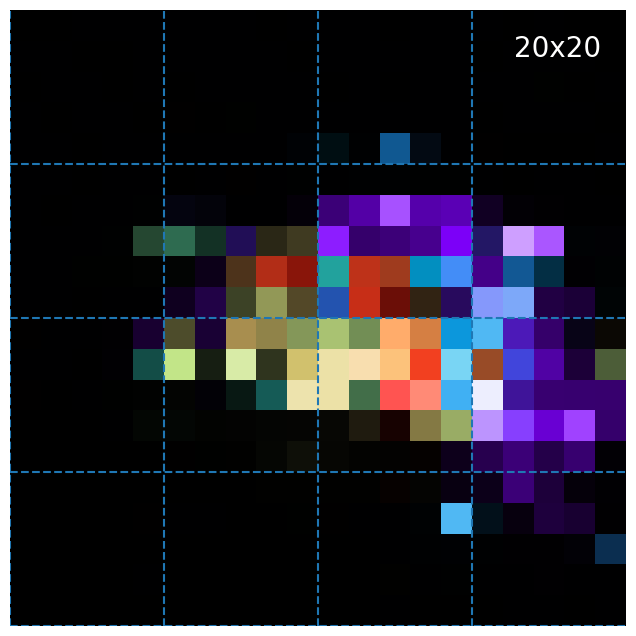

In [138]:
f, ax = plt.subplots(1,1,figsize=(8, 8))
plot_maxmap(ax, x0, ys0, xrange=xrange, yrange=[vmin, vmax*0.9])
a, b = ys0.shape[1:]
ax.scatter(3,3, alpha=0,label=f'{a}x{b}')
ax.legend(loc='upper right', framealpha=0, labelcolor='w', fontsize=20)
for i in range(4):
    ax.axvline(i*5-0.5, ls='--')
    ax.axhline(i*5-0.5, ls='--')

Text(0.5, 0, 'Wavelength (nm)')

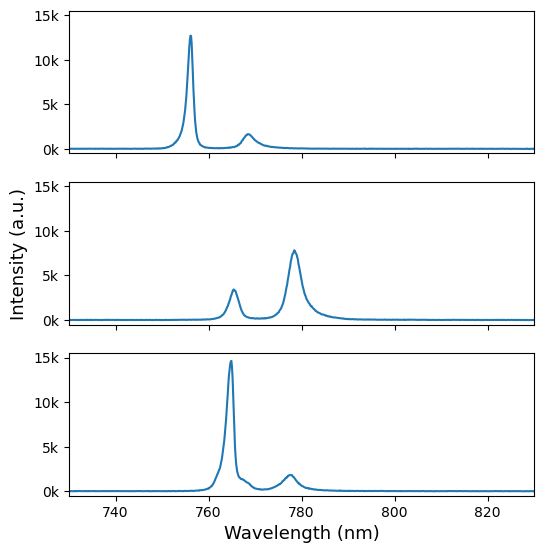

In [152]:
f, axs = plt.subplots(3,1,figsize=(6, 6.3), sharex=True)
axs[0].plot(x0, ys0[:,13,12])
axs[1].plot(x0, ys0[:,10,11])
axs[2].plot(x0, ys0[:,8,14])
for ax in axs:
    ax.set_xlim([730, 830])
    ax.set_ylim([-500, 15500])
    ax.set_yticks([i*5000 for i in range(4)], labels=[f'{5*i}k' for i in range(4)])
axs[1].set_ylabel('Intensity (a.u.)', fontsize=13)
axs[-1].set_xlabel('Wavelength (nm)', fontsize=13)
    

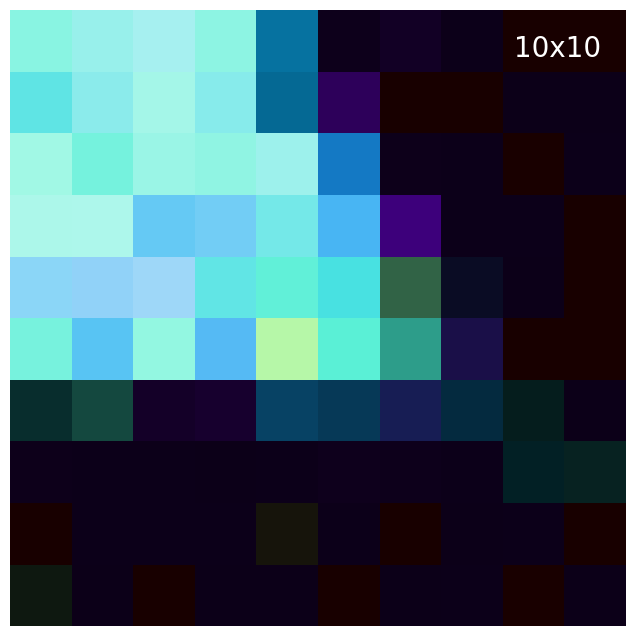

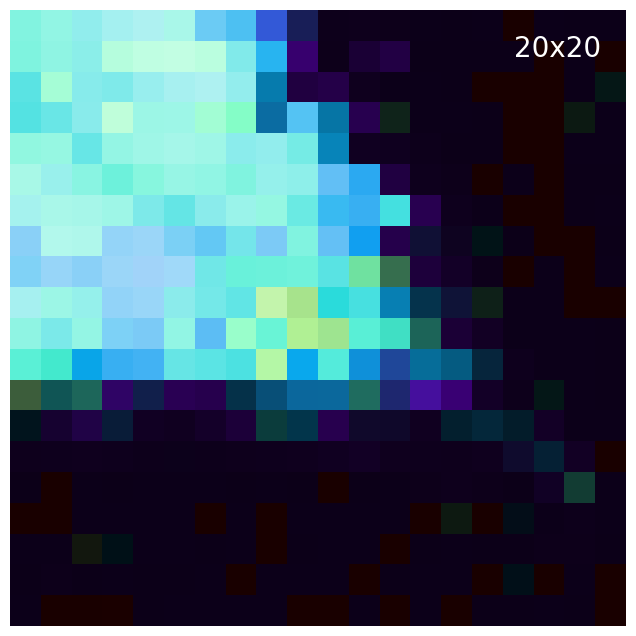

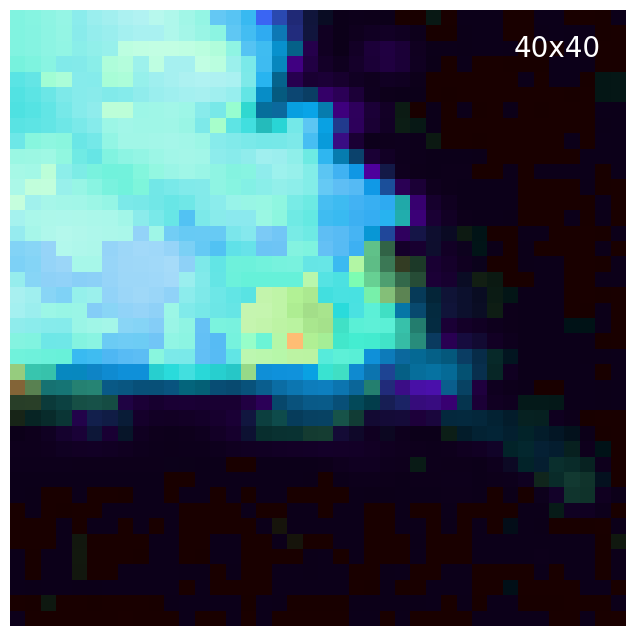

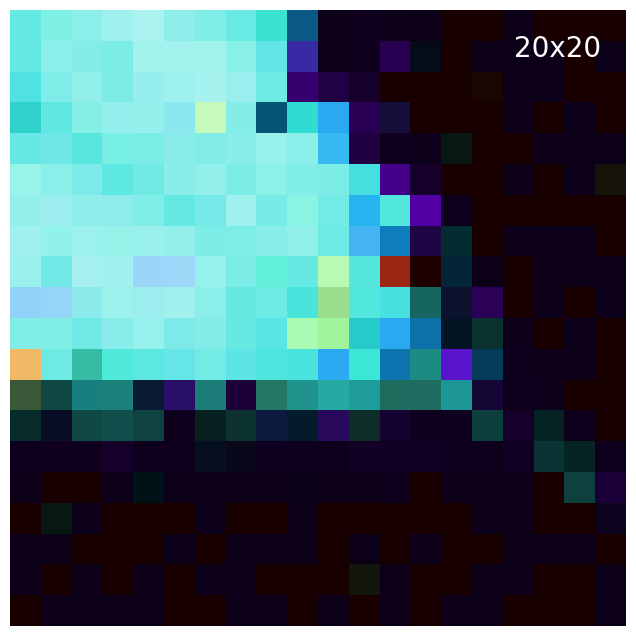

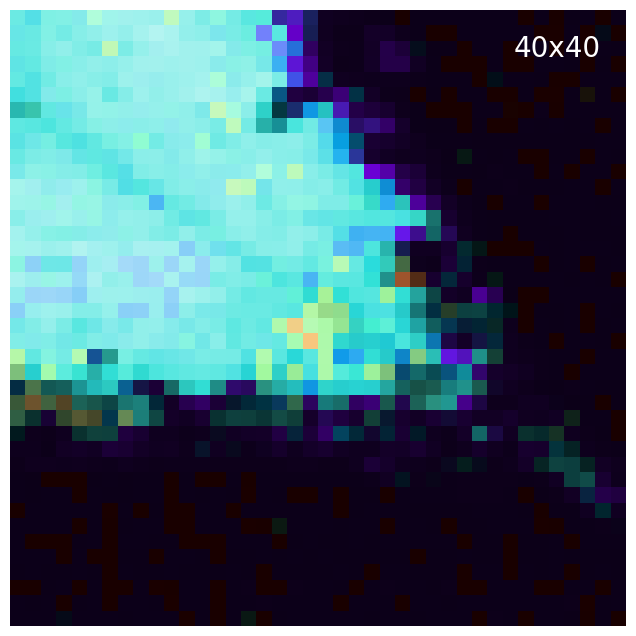

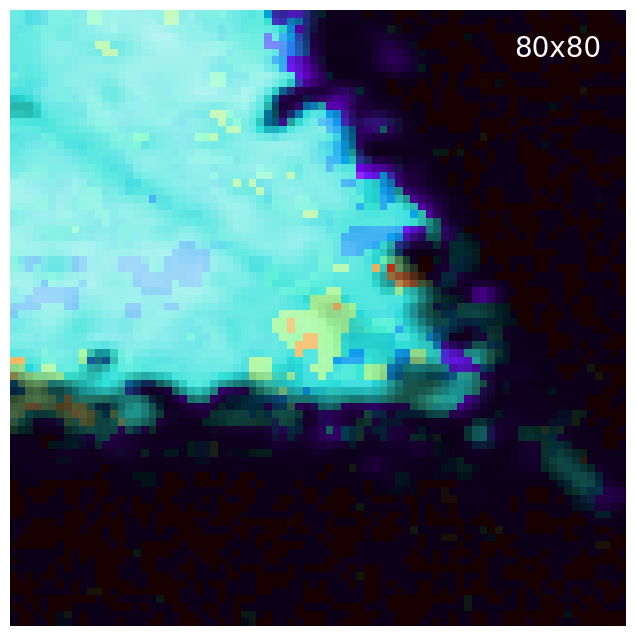

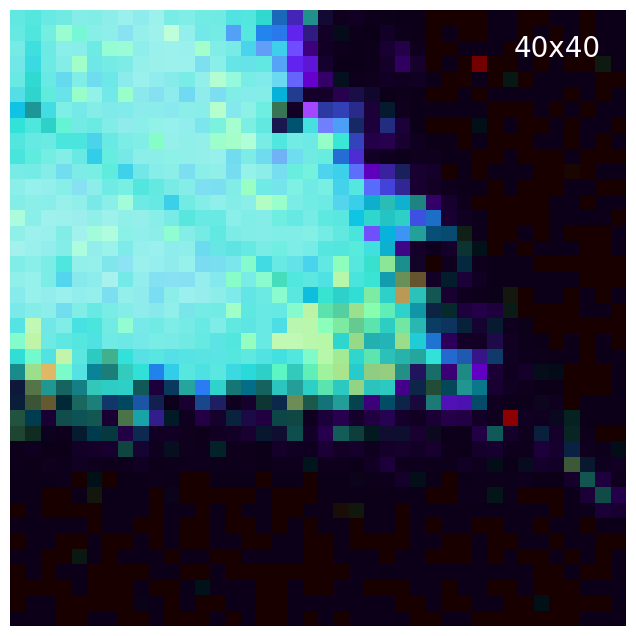

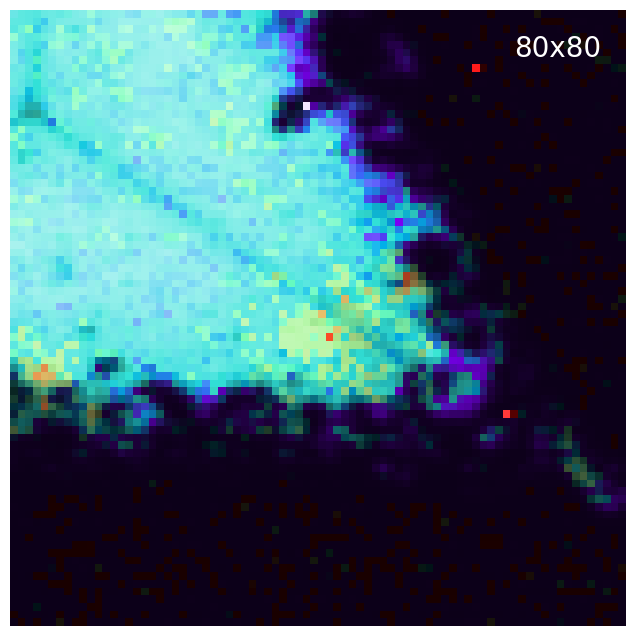

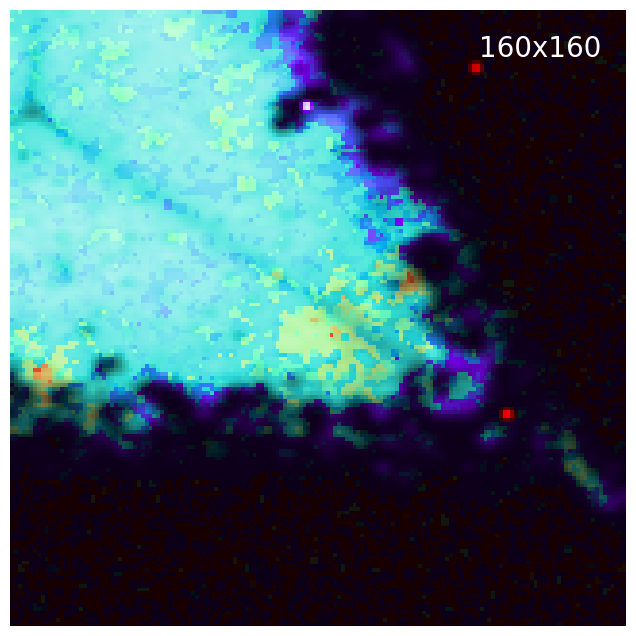

In [71]:
for x, y in zip([x1, x1, x1, x2, x2, x2, x3, x3, x3], [ys1_d, ys1, ys1_u, ys2_d, ys2, ys2_u, ys3_d, ys3, ys3_u]):
    f, ax = plt.subplots(1,1,figsize=(8, 8))
    plot_maxmap(ax, x, y, xrange=[630, 640], yrange=[vmin, vmax])
    a, b = y.shape[1:]
    ax.scatter(5,5, alpha=0,label=f'{a}x{b}')
    ax.legend(loc='upper right', framealpha=0, labelcolor='w', fontsize=20)



- interpolation test

In [55]:

import torch, sys
sys.path.append('..')
from utils.spectrum import read_spectrum
from utils.visualize import plot_maxmap
from torch.nn.functional import interpolate
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

x2, ys2 = read_spectrum(692)
x3, ys3 = read_spectrum(693)

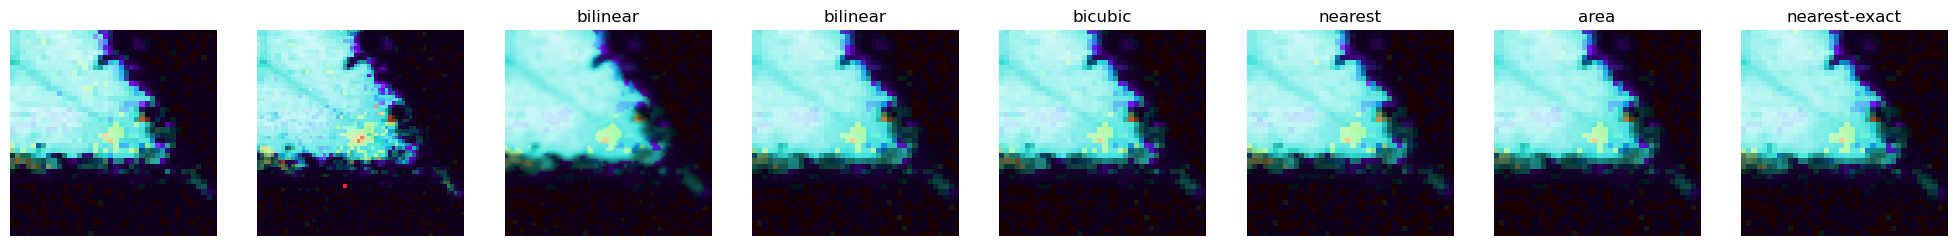

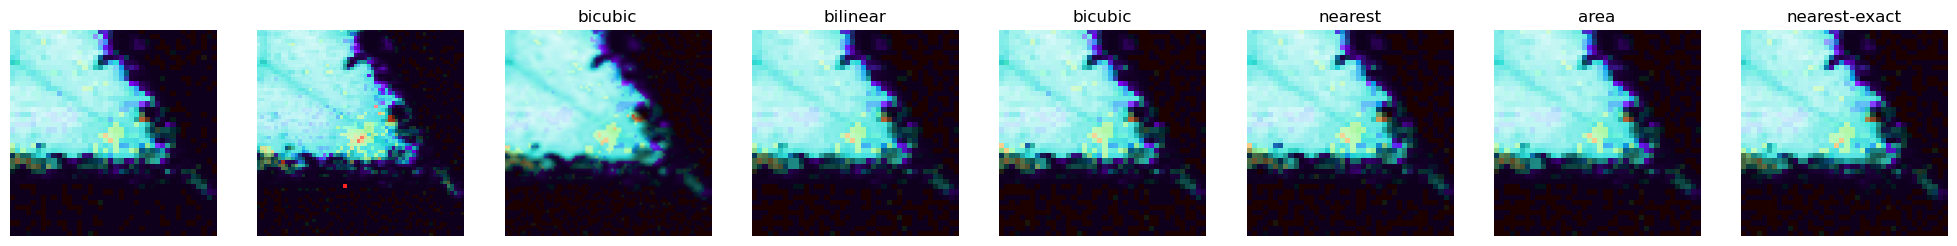

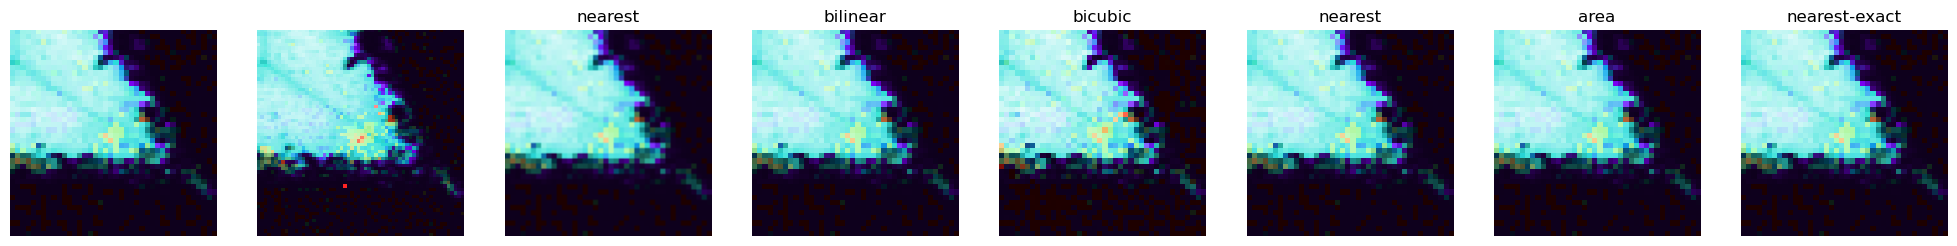

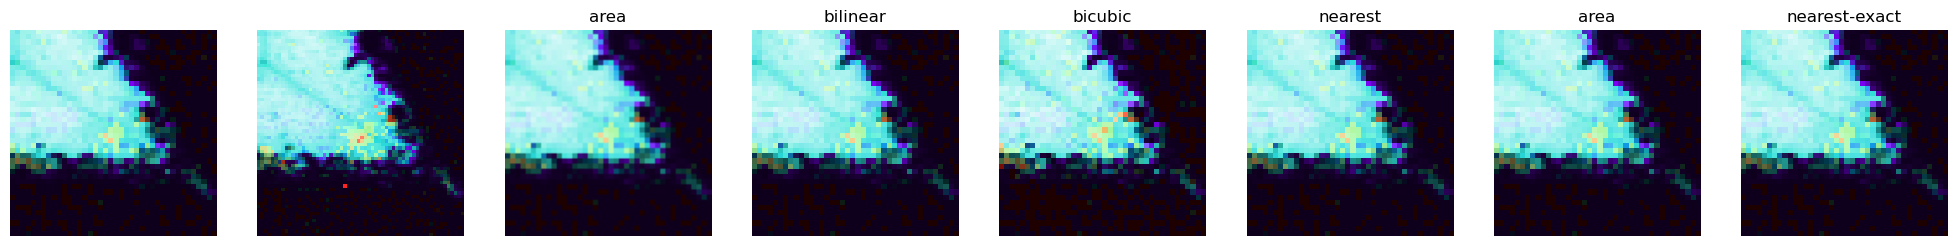

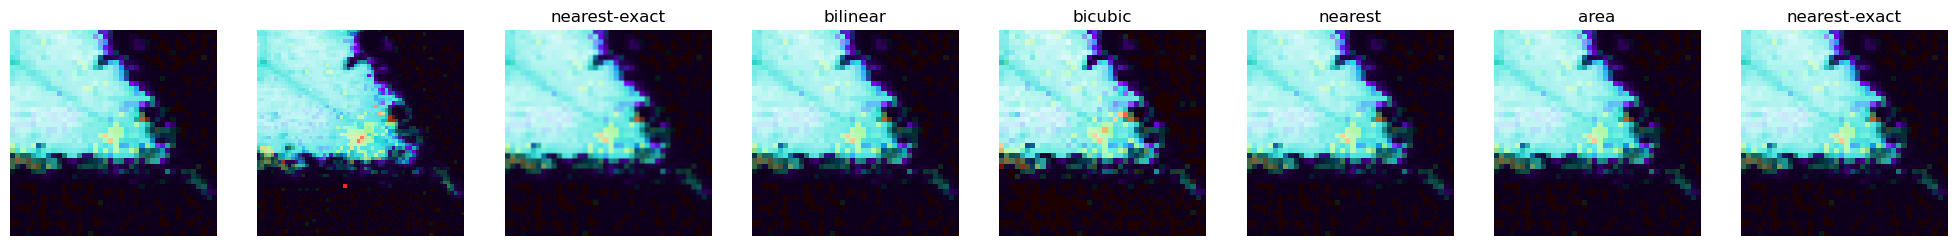

In [58]:
yst = torch.tensor(ys2).float().unsqueeze(1)
mode = ['bilinear','bicubic','nearest','area','nearest-exact']
xrange=[630, 640]
yrange=[700, 1300]

for m1 in mode:
    f, axs = plt.subplots(1, 8, figsize=(25,12))
    y_up = interpolate(yst, scale_factor=2, mode=m1)
    plot_maxmap(axs[0], x2, ys2, xrange=xrange, yrange=yrange)
    plot_maxmap(axs[1], x3, ys3, xrange=xrange, yrange=yrange)
    plot_maxmap(axs[2], x2, y_up.numpy().squeeze(), xrange=xrange, yrange=yrange)
    axs[2].set_title(m1)
    for ax, m2 in zip(axs[3:], mode):
        ax.set_title(m2)
        ys = interpolate(y_up, scale_factor=0.5, mode=m2).numpy().squeeze()
        plot_maxmap(ax, x2, ys, xrange=xrange, yrange=yrange)


In [43]:
from utils.spectrum import spectrum_correlations
spectrum_correlations(yss['bicubic'], yss['bilinear']).reshape(80,80)

array([[0.99123756, 0.9947278 , 0.98927954, ..., 0.98919744, 0.99514994,
        0.99190406],
       [0.99456605, 0.99829061, 0.99245846, ..., 0.99182396, 0.99830687,
        0.99516941],
       [0.98686938, 0.99061249, 0.98508854, ..., 0.98285824, 0.99022649,
        0.98696863],
       ...,
       [0.99996736, 0.99998382, 0.99994347, ..., 0.98435554, 0.99012679,
        0.98723901],
       [0.99997096, 0.99999747, 0.9999693 , ..., 0.99237301, 0.99841594,
        0.99481115],
       [0.99990411, 0.9999759 , 0.9999349 , ..., 0.98834371, 0.99502149,
        0.9913787 ]])

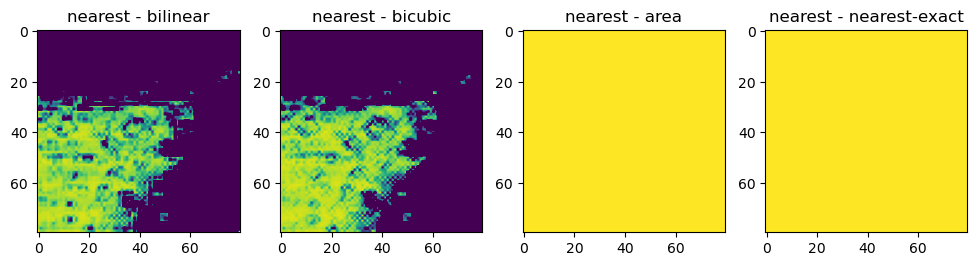

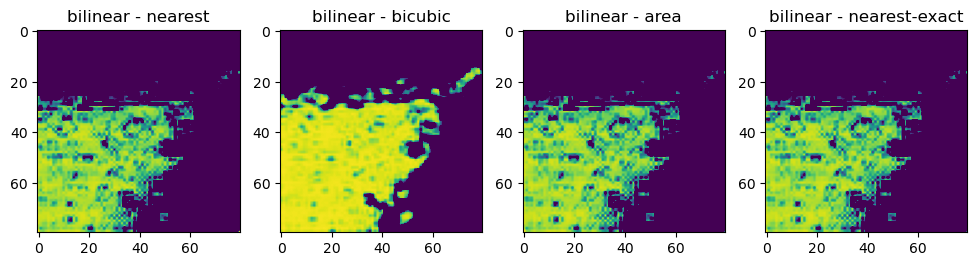

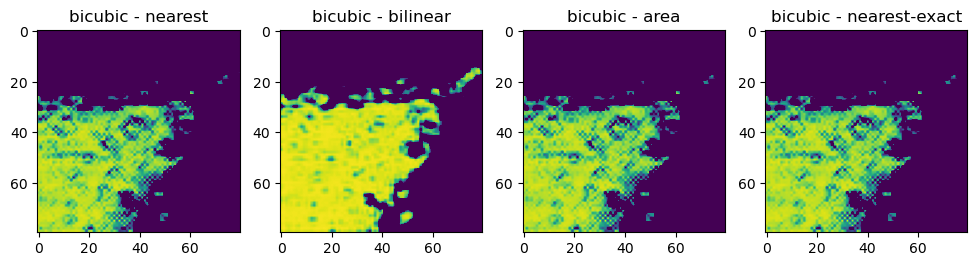

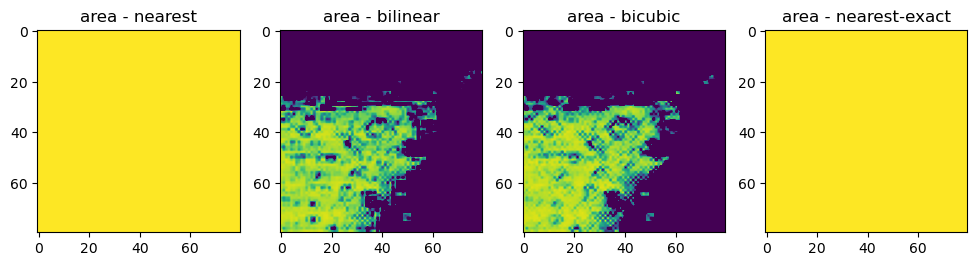

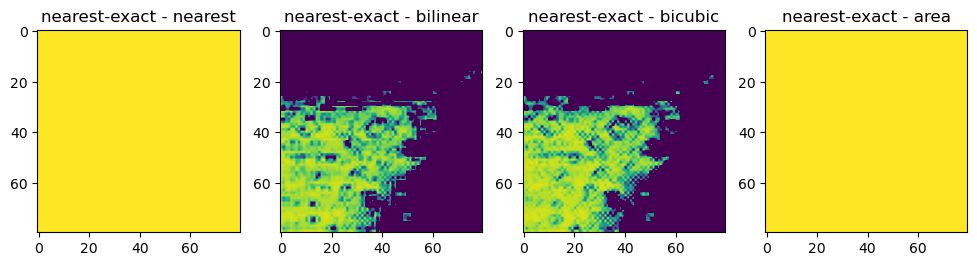

In [49]:
from utils.spectrum import spectrum_correlations

for k1, ys_1 in yss.items():
    if k1 == 'orig': continue
    f, axs = plt.subplots(1,4,figsize=(12,4))
    k = 0
    for k2, ys_2 in yss.items():
        if k2 == 'orig': continue
        if k1 == k2: continue
        axs[k].imshow(spectrum_correlations(ys_1, ys_2).reshape(80,80), vmin=0.999, vmax=1)
        axs[k].set_title(f'{k1} - {k2}')
        k += 1

- autoencoder

In [4]:
SAE = SpectrumAutoEncoder(2, 8, 32, 512, 4, kernel_size=8)
SAE.to('cuda')
opt = torch.optim.AdamW(SAE.parameters(), lr=1e-3)
trainer = SAETrainer(SAE, opt)
logging = 100
losses = [[],[]]
outputs = {}
times = []
for i in range(1000):
    t1 = time.time()
    epoch = i + 1
    train_loss = trainer.train(train_dl)
    losses[0].append([epoch, train_loss])
    print(f'{epoch:4d} / {train_loss:.5f}',end='\r')
    times.append(time.time() - t1)
    if epoch%logging == 0:
        valid_loss, output = trainer.test(valid_dl)
        output.update(trainer.pred(test_dl))
        losses[1].append([epoch, valid_loss])
        print(f'{epoch:4d} / {train_loss:9.5f} / {valid_loss:9.5f} ({1/np.mean(times):.2f} it/s)')
        times = []
        outputs[epoch] = output

/mnt/CODES/PL_model/package/notebooks/../utils/trainer.py:232: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  m = v['x'] != 0


 100 /   0.00351 /   0.00353 (4.71 it/s)
 200 /   0.00329 /   0.00335 (4.80 it/s)
 300 /   0.00317 /   0.00322 (4.82 it/s)
 400 /   0.00311 /   0.00310 (4.82 it/s)
 500 /   0.00295 /   0.00302 (4.95 it/s)
 600 /   0.00286 /   0.00304 (4.80 it/s)
 700 /   0.00292 /   0.00288 (4.78 it/s)
 800 /   0.00283 /   0.00307 (4.80 it/s)
 900 /   0.00280 /   0.00304 (4.80 it/s)
1000 /   0.00279 /   0.00283 (4.79 it/s)


- super resolution

In [47]:
from torch import nn
from srs.base_networks import NetBlock

class TNet(nn.Module):
    def __init__(self, num_channels, base_filter, feat, num_stages, residual=True):
        super(TNet, self).__init__()
        
        self.num_stages = num_stages
        self.residual = residual
        
        self.embed0 = ConvBlock(num_channels, feat, 3, 1, 1, activation='prelu', norm=None)
        self.embed1 = ConvBlock(feat, base_filter, 1, 1, 0, activation='prelu', norm=None)
        
        self.block1 = NetBlock(base_filter, 4, 2, 2, 1)
        self.block2 = NetBlock(base_filter, 8, 4, 4, 2)
        self.block3 = NetBlock(base_filter, 16, 8, 8, 3)
        self.block4 = NetBlock(base_filter, 32, 16, 16, 4)
        self.block5 = NetBlock(base_filter, 64, 32, 32, 5)
        self.block6 = NetBlock(base_filter, 128, 64, 64, 6)
        
        self.output_conv = ConvBlock(base_filter * self.num_stages, 1, 3, 1, 1, activation=None, norm=None)
        
        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv1d') != -1:
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif classname.find('ConvTranspose1d') != -1:
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        h = self.embed0(x)
        h = self.embed1(h)
        
        results = []
        for _ in range(self.num_stages):
            h0 = self.block1(h)
            cat_h = torch.concat([h0, h], dim=1)
            h = self.block2(cat_h)
            cat_h = torch.concat([h, cat_h], dim=1)
            h = self.block3(cat_h)
            cat_h = torch.concat([h, cat_h], dim=1)
            h = self.block4(cat_h)
            cat_h = torch.concat([h, cat_h], dim=1)
            h = self.block5(cat_h)
            cat_h = torch.concat([h, cat_h], dim=1)
            h = self.block6(cat_h)
            
            results.append(h)
        
        result = torch.cat(results, 1)
        out = self.output_conv(result)
        if self.residual:
            out = out + x[:,:1]
        return out

In [66]:
SSR = TNet(2, 8, 32, 3, False)
SSR.to('cuda')
opt = torch.optim.AdamW(SSR.parameters(), lr=1e-3)
trainer = SSRNetTrainer(SSR, opt)
logging = 20
losses = [[],[]]
outputs = {}
times = []
for i in range(1000):
    t1 = time.time()
    epoch = i + 1
    train_loss = trainer.train(train_dl)
    losses[0].append([epoch, train_loss])
    print(f'{epoch:4d} / {train_loss:.5f}',end='\r')
    times.append(time.time() - t1)
    if epoch%logging == 0:
        valid_loss, output = trainer.test(valid_dl)
        output.update(trainer.pred(test_dl))
        losses[1].append([epoch, valid_loss])
        print(f'{epoch:4d} / {train_loss:9.5f} / {valid_loss:9.5f} ({1/np.mean(times):.2f} it/s)')
        times = []
        outputs[epoch] = output

  20 /   0.02062 /   0.02252 (7.80 it/s)
  40 /   0.01672 /   0.01631 (7.85 it/s)
  60 /   0.01329 /   0.01530 (7.90 it/s)
  80 /   0.01533 /   0.01728 (7.86 it/s)
 100 /   0.01319 /   0.01634 (7.90 it/s)
 120 /   0.01359 /   0.01624 (7.87 it/s)
 140 /   0.01393 /   0.01702 (7.90 it/s)
 160 /   0.01175 /   0.01644 (7.87 it/s)
 180 /   0.01066 /   0.01408 (7.88 it/s)
 200 /   0.01091 /   0.01393 (7.81 it/s)
 220 /   0.01095 /   0.01399 (7.83 it/s)
 240 /   0.01082 /   0.01381 (7.89 it/s)
 260 /   0.01024 /   0.01470 (7.87 it/s)
 280 /   0.01257 /   0.01584 (7.88 it/s)
 300 /   0.01322 /   0.01714 (7.85 it/s)
 320 /   0.01173 /   0.01743 (7.89 it/s)
 340 /   0.01267 /   0.01615 (7.84 it/s)
 360 /   0.01058 /   0.01406 (7.85 it/s)
 380 /   0.01056 /   0.01405 (7.82 it/s)
 400 /   0.00971 /   0.01424 (7.81 it/s)
 420 /   0.00981 /   0.01373 (7.87 it/s)
 440 /   0.01055 /   0.01595 (7.82 it/s)
 460 /   0.01107 /   0.01418 (7.87 it/s)
 480 /   0.00962 /   0.01339 (7.82 it/s)
 500 /   0.01074

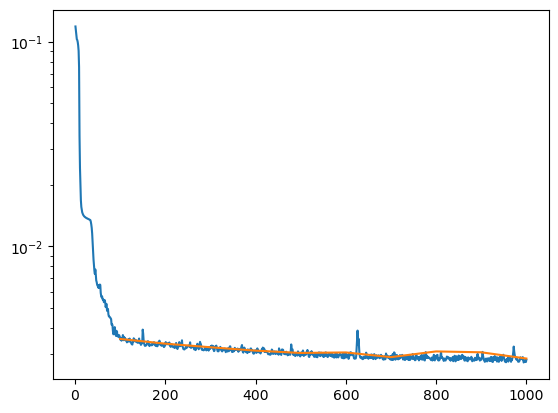

In [5]:
import matplotlib.pyplot as plt
plt.plot(*np.array(losses[0]).T)
plt.plot(*np.array(losses[1]).T)
plt.yscale('log')

In [6]:
outputs[1000].keys()

dict_keys(['668.txt', '670.txt', '666_8x.txt', '668_4x.txt'])

In [9]:
v = outputs[1000]['668.txt']
#v = outputs[1000]['670.txt']
x0 = v['x']
x1 = v['x']
ys0 = denorm_spectrum(v['pred'], v['vmin'], v['vmax']).squeeze()
ys1 = denorm_spectrum(v['tgt'], v['vmin'], v['vmax']).squeeze()
#x0, ys0 = read_spectrum(668)
#x1, ys1 = read_spectrum('668_4x.txt', root='../test/dbpn/s79r/00050.test')
v = outputs[1000]['670.txt']
#v = outputs[1000]['668_4x.txt']
x2 = v['x']
x3 = v['x']
ys2 = denorm_spectrum(v['pred'], v['vmin'], v['vmax']).squeeze()
ys3 = denorm_spectrum(v['tgt'], v['vmin'], v['vmax']).squeeze()

TypeError: unsupported operand type(s) for -: 'numpy.str_' and 'numpy.str_'

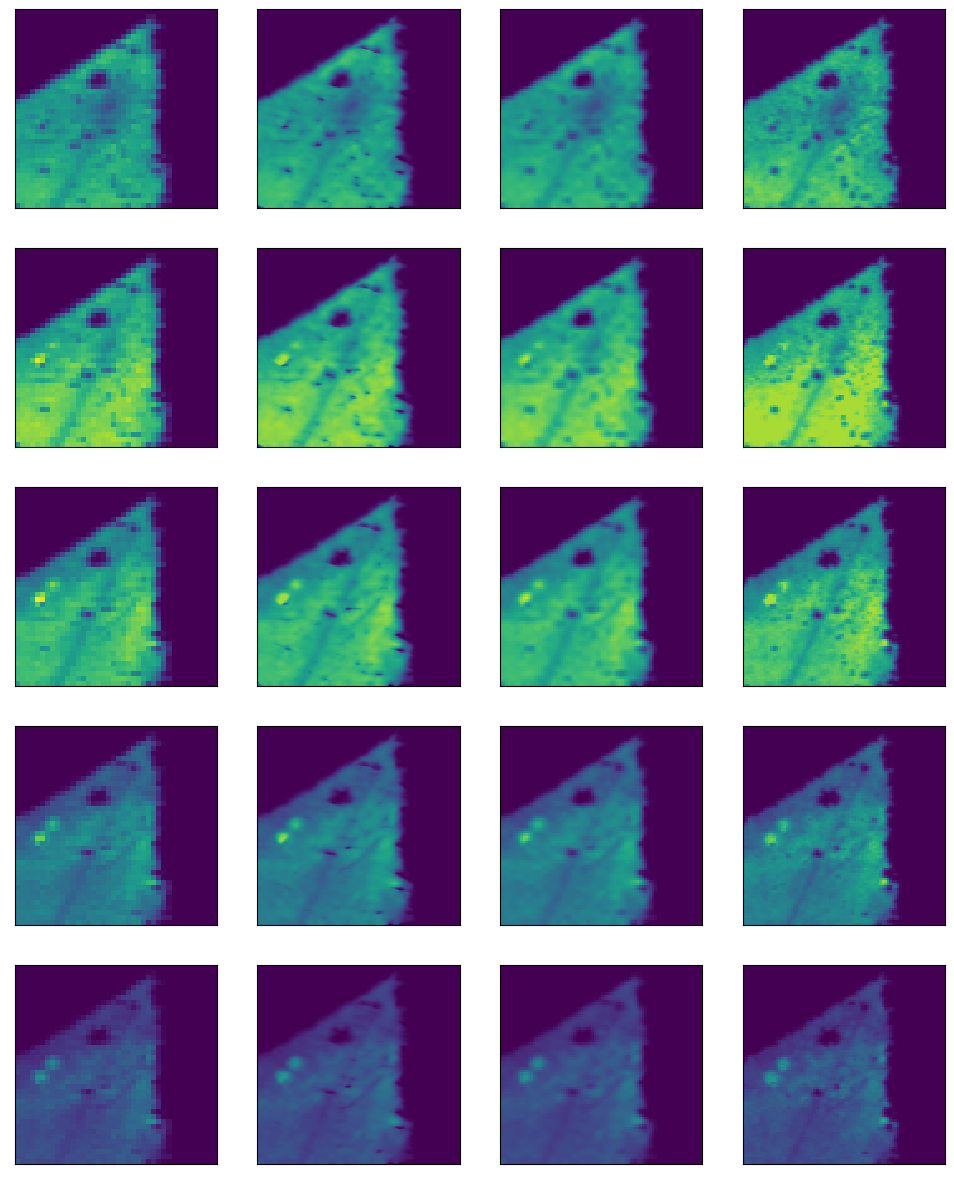

In [81]:
from utils.visualize import plot_maxmap, plot_map
locs = [630, 635, 640, 645, 650]
f, axs = plt.subplots(len(locs),5,figsize=(14, 3*len(locs)))
for loc, ax in zip(locs, axs):
    plot_map(ax[0], x0, ys0, loc=loc, tol=1, vmin=v['vmin'], vmax=1.1*v['vmax'])
    plot_map(ax[1], xb, bic, loc=loc, tol=1, vmin=v['vmin'], vmax=1.1*v['vmax'])
    plot_map(ax[2], x2, ys1, loc=loc, tol=1, vmin=v['vmin'], vmax=1.1*v['vmax'])
    plot_map(ax[3], x3, ys2, loc=loc, tol=1, vmin=v['vmin'], vmax=1.1*v['vmax'])
    plot_map(ax[4], x3, ys3, loc=loc, tol=1, vmin=v['vmin'], vmax=1.1*v['vmax'])
f.subplots_adjust(wspace=0.05, hspace=0.05)

In [227]:
torch.tensor(x1.astype(float)).float().expand(ys1.shape)

tensor([[602.3970, 602.5640, 602.7310,  ..., 687.1680, 687.3340, 720.8060],
        [602.3970, 602.5640, 602.7310,  ..., 687.1680, 687.3340, 720.8060],
        [602.3970, 602.5640, 602.7310,  ..., 687.1680, 687.3340, 720.8060],
        ...,
        [602.3970, 602.5640, 602.7310,  ..., 687.1680, 687.3340, 720.8060],
        [602.3970, 602.5640, 602.7310,  ..., 687.1680, 687.3340, 720.8060],
        [602.3970, 602.5640, 602.7310,  ..., 687.1680, 687.3340, 720.8060]])

NameError: name 'ys0' is not defined

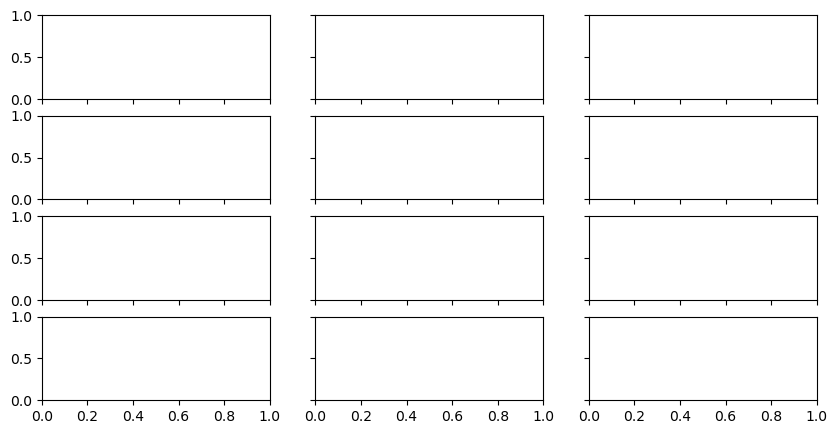

In [10]:
base = 1600 
f, axs = plt.subplots(4, 3, figsize=(10, 5), sharex=True, sharey=True)
for i, ax in enumerate(axs.reshape(-1)):
    ax.plot(x0, ys0.reshape(x0.shape[0], -1).T[i+base])
    ax.plot(x1, ys1[i+base])
    ax.plot(x1, ys2[i+base])

In [184]:
outputs[1000].keys()

dict_keys(['419.txt', '421.txt', '420_2x_421.txt', '421_2x_419.txt', '420_8x.txt', '421_4x.txt'])

In [6]:
ys = denorm_spectrum(v['tgt'], v['vmin'], v['vmax'])
SSD2.from_data(v['x'], ys)

In [7]:
x, ys = read_spectrum(666, transpose_y=False)
ys.shape

(20, 20, 1600)

In [8]:
from utils.spectrum import get_mask
m1 = get_mask(x, x)
m2 = get_mask(x, v['x'])
m3 = get_mask(v['x'], v['x'])

In [9]:
m1.shape, m2.shape, m3.shape, np.sum(m1), np.sum(m2), np.sum(m3)

((1600,), (1600,), (512,), 1600, 512, 512)

In [50]:
import torch
y = torch.ones((200, 124))
m, n = y.shape
t = torch.zeros((m, 128 - n%128))
torch.hstack([y, t]).shape

torch.Size([200, 128])

In [11]:
bic2, tgt2, info2 = collate_fn(SSD2)

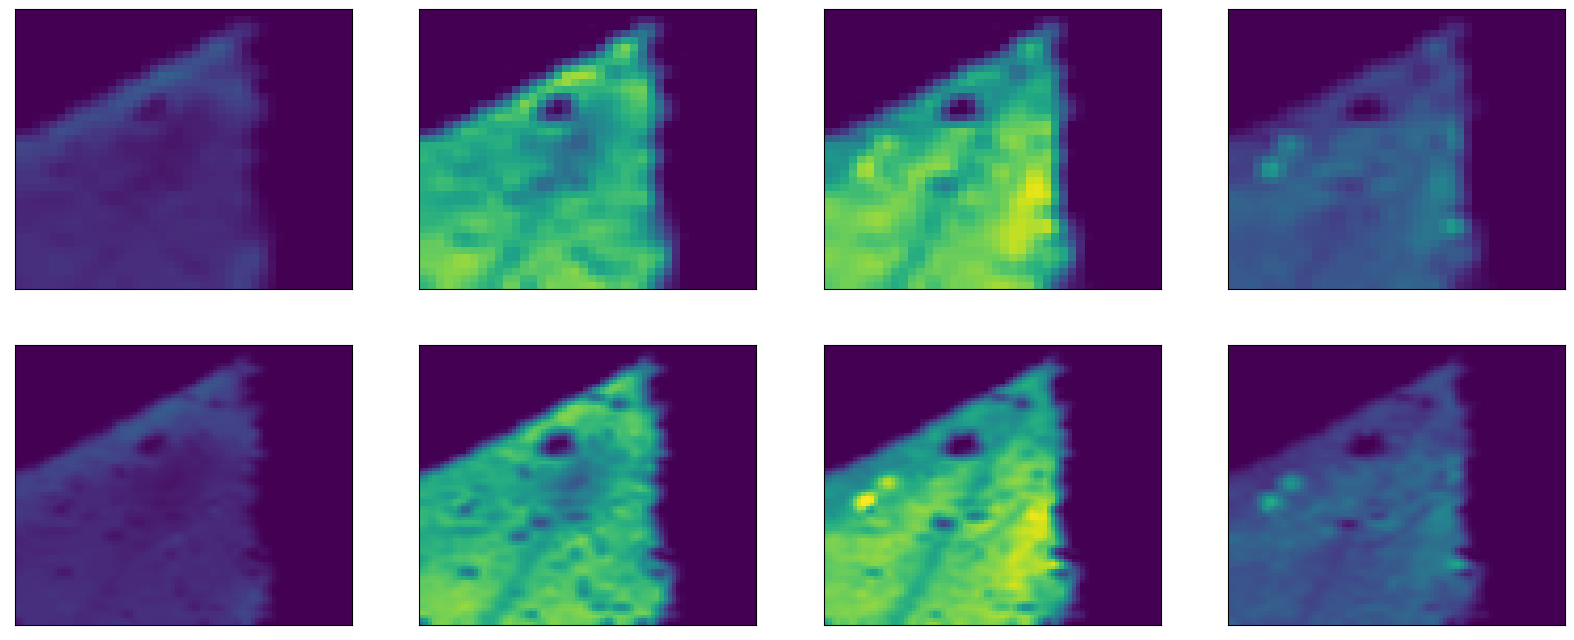

In [12]:
f, axs = plt.subplots(2, 4, figsize=(20,8))
locs = [620, 630, 640, 650]
for ax, loc in zip(axs.T, locs):
    plot_map(ax[0], v['x'], v['bic'], loc=loc, tol=1, vmin=0, vmax=1)
    plot_map(ax[1], v['x'], bic2.squeeze().numpy(), loc=loc, tol=1, vmin=0, vmax=1)

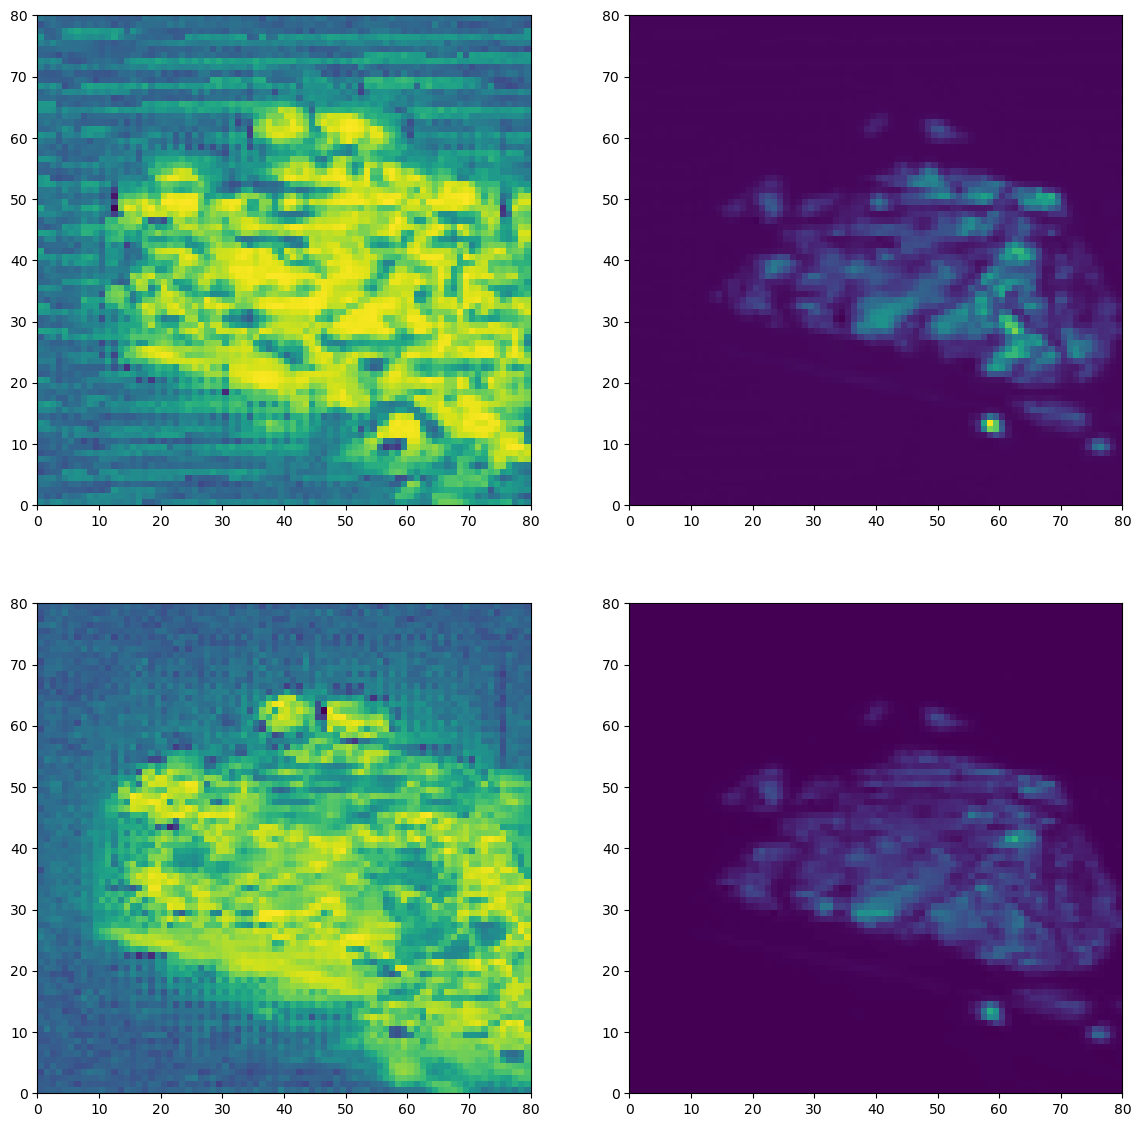

In [43]:
from utils.spectrum import spectrum_correlations
nys0 = np.max(ys0, axis=0)/np.max(ys0)
f, axs = plt.subplots(2,2,figsize=(14, 14))
corrs = spectrum_correlations(ys0, ys1)
axs[0,0].pcolormesh(corrs.reshape(80,80), vmax=1)
axs[0,1].pcolormesh(corrs.reshape(80,80) * nys0, vmax=1)
corrs = spectrum_correlations(ys0, ys2)
axs[1,0].pcolormesh(corrs.reshape(80,80), vmax=1)
axs[1,1].pcolormesh(corrs.reshape(80,80) * nys0, vmax=1)

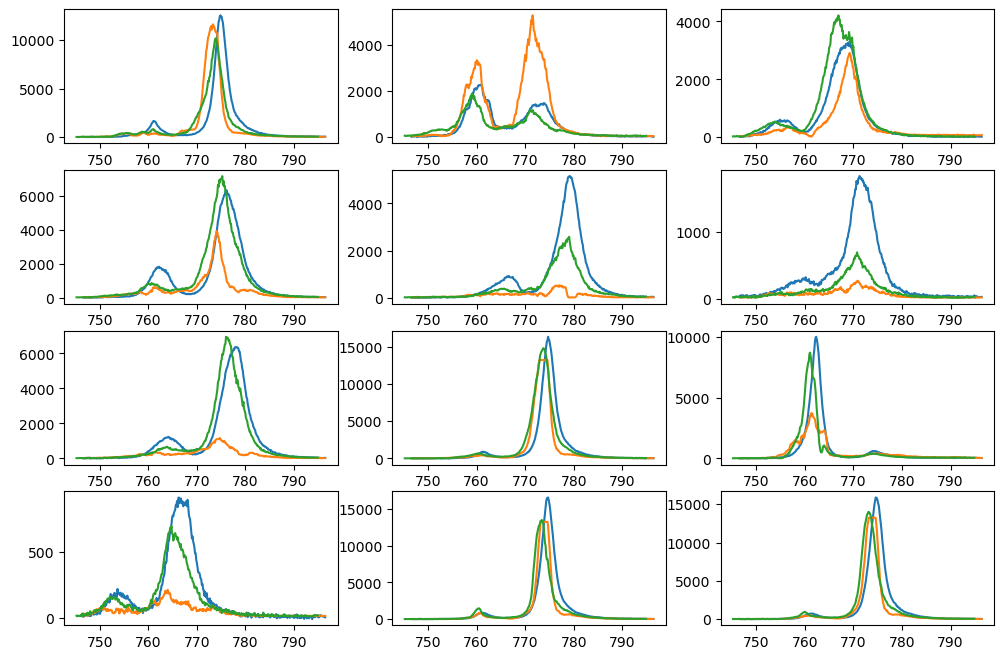

In [49]:
f, axs = plt.subplots(4, 3, figsize=(12, 8))
axs = axs.reshape(-1)
n = x0.shape[0]
for i, ax in zip(np.argsort(corrs)[-len(axs):], axs):
    ax.plot(x0, ys0.reshape(n,-1).T[i])
    ax.plot(x1, ys1.reshape(n,-1).T[i])
    ax.plot(x2, ys2.reshape(n,-1).T[i])
    

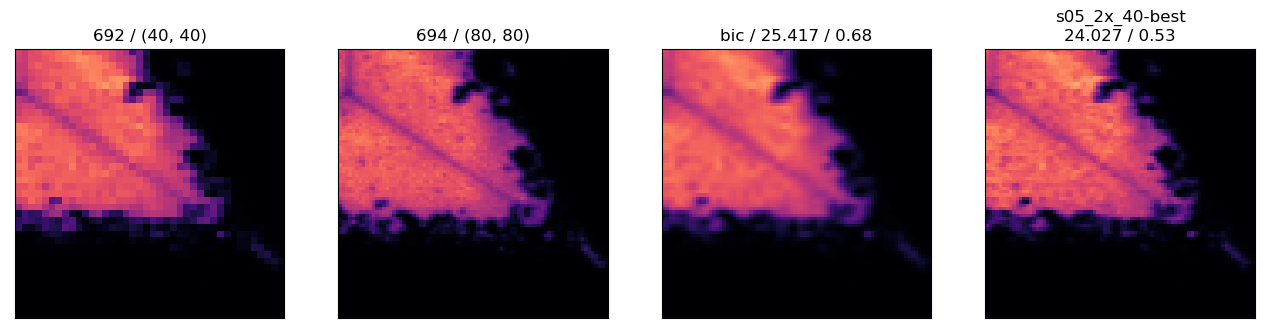

In [81]:
#locs = [626, 630, 634, 638, 642, 646]
locs = [638]
idxs = [0, 1,  3, 4]
f, axs = plt.subplots(len(locs), len(idxs), figsize=(len(idxs)*4, len(locs)*3.5))
axs = axs.reshape(-1,1)
#f, axs = plt.subplots(len(idxs), len(locs), figsize=(len(locs)*3.5, len(idxs)*4))
for ax, i in zip(axs, idxs):
    ax[0].set_title(titles[i])
    for _ax, loc in zip(ax, locs):
        plot_map(_ax, x, outputs[i], loc=loc, tol=0.2, vmin=vmin, vmax=vmax, cmap='magma')

In [83]:
measures[3][1][np.argmin(np.abs(x - 638))], measures[5][1][np.argmin(np.abs(x - 638))]

(0.6942027069940407, 0.5430204621384691)

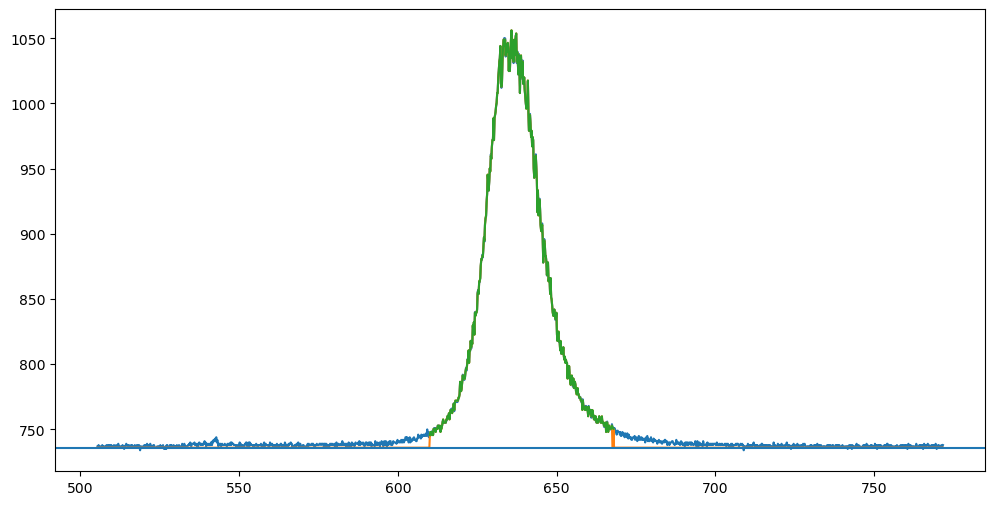

In [88]:
i, j = (20, 20)
m = x.reshape(-1,1) - x_.reshape(1,-1)
idxs = np.argmin(np.abs(m), axis=0)
yy = np.ones_like(y)*vmin
yy[idxs] = y_
f, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=True, sharey=True)
ax.plot(x, y[:, i,j])
ax.plot(x, yy[:, i,j])
ax.plot(x_, y_[:, i,j])
ax.axhline(vmin)

In [43]:
x1, ys1 = read_spectrum(729)
x2, ys2 = read_spectrum(769)

TypeError: 'NoneType' object is not subscriptable

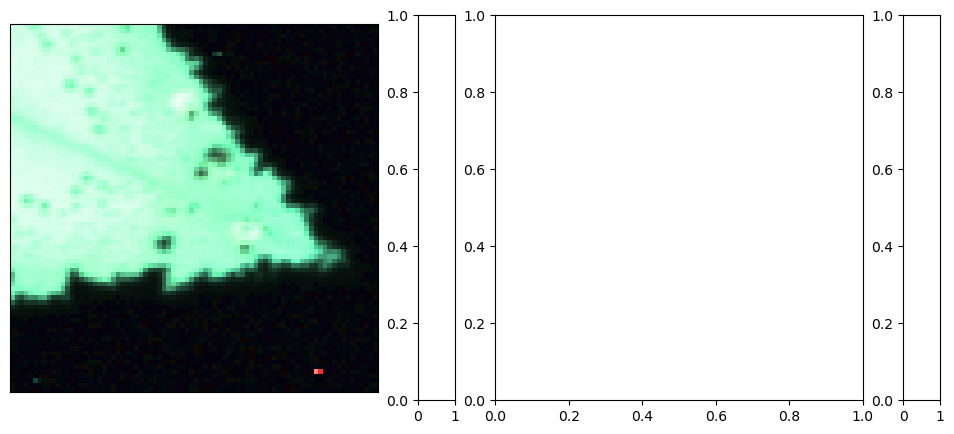

In [47]:
f, axs = plt.subplots(1,4,figsize=(12, 5), width_ratios=[1,0.1,1,0.1])

plot_maxmap(axs[0], x1, ys1, xrange=, cax=axs[1], aspect_ratio=4)

plot_maxmap(axs[2], x2, ys2, xrange=, cax=axs[3], aspect_ratio=4)
